In [390]:
import pandas as pd
import numpy as np
import os
from io import StringIO
import re
import csv

from tabulate import tabulate

import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import graphviz

from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

import pydotplus

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 400)

os.getcwd()



'/Users/lubagloukhov/Documents/Consulting/PiqueSolutions/JavaSE_202007/scripts'

In [473]:
%run -i 'functions.py'

<Figure size 1440x720 with 0 Axes>

In [424]:
mod_df = pd.read_csv('../data/output/mod_df.csv')  
catg_dummy_list = open('../data/output/catg_dummy_list.csv').read().splitlines()
cont_dummy_list = open('../data/output/cont_dummy_list.csv').read().splitlines()
dummy0_dummy_list = open('../data/output/dummy0_dummy_list.csv').read().splitlines()
exlc_dummy_list = open('../data/output/exlc_dummy_list.csv').read().splitlines()

In [72]:
# response candidates
[i for i in catg_dummy_list + cont_dummy_list + dummy0_dummy_list if 'Sat' in i] 

['Sat_Org_EclipseIDE',
 'Sat_Org_IntelliJIDE',
 'Sat_Org_JDeveloper',
 'Sat_Org_NetBeansIDE',
 'Sat_Org_RationalAppDev',
 'Sat_Org_VisualStudio',
 'Sat_Org_Other',
 'Sat_Org_JavaSEAMC',
 'Sat_Org_JavaSEAMC_UsageLog',
 'Sat_Org_JavaSEDepRuleSet',
 'Sat_Org_JavaSEMSICustTools',
 'Sat_Org_JavaSEFlightRec',
 'OJavaSESubscription_Elem_Sat_Org_ContinuedInvest',
 'OJavaSESubscription_Elem_Sat_Org_PatchesOlderV',
 'OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates',
 'OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates',
 'OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools',
 'OJavaSESubscription_Elem_Sat_Org_Monitoring',
 'OJavaSESubscription_Elem_Sat_Org_MyOSupport',
 'OJavaSESubscription_Elem_Sat_Org_AccessCloud',
 'OJavaSESubscription_Elem_Sat_Org_FlexLicensing',
 'OJavaSESubscription_Elem_Sat_Org_LegacyJava',
 'OJavaSESubscription_Elem_Sat_Org_Other',
 'OJavaSESubscription_Attr_Sat_CommMethods',
 'OJavaSESubscription_Attr_Sat_PhoneSupport',
 'OJavaSESubscription_Attr_Sat_SSKnowledge',


In [73]:
predictors = catg_dummy_list + cont_dummy_list + dummy0_dummy_list
response = 'OJavaSESubscription_Elem_Sat_Org_ContinuedInvest'

X = mod_df[predictors].drop(response, axis=1)
y = mod_df[response]

X = X.fillna(X.mean())
y = y.fillna(y.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeRegressor(random_state=0)

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

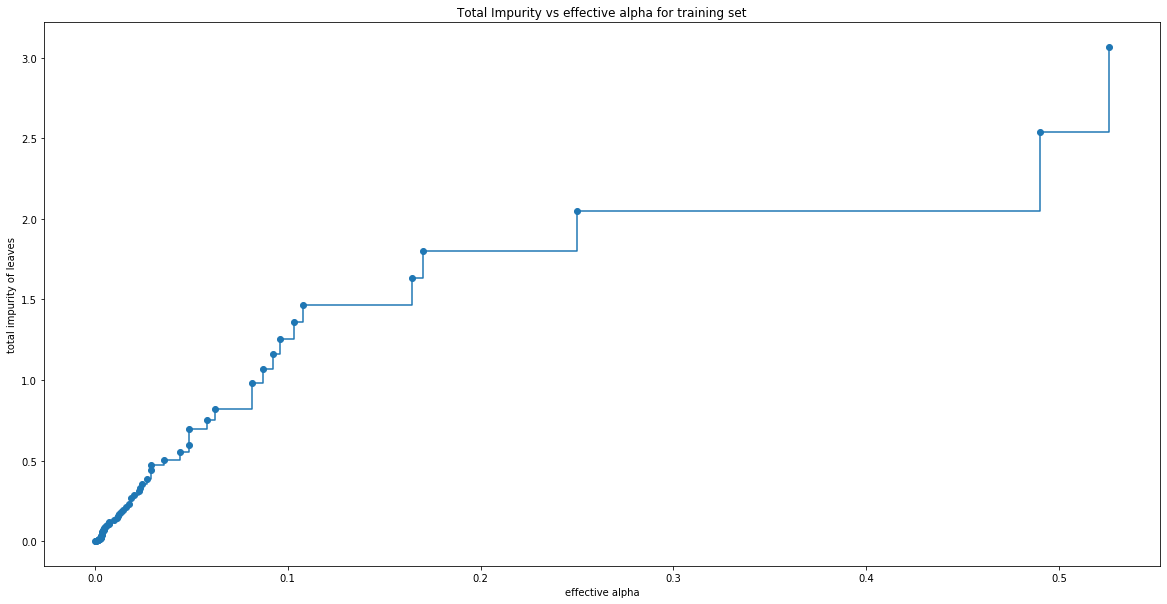

In [78]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [79]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Number of nodes in the last tree is: 1 with ccp_alpha: 1.9724947028815825


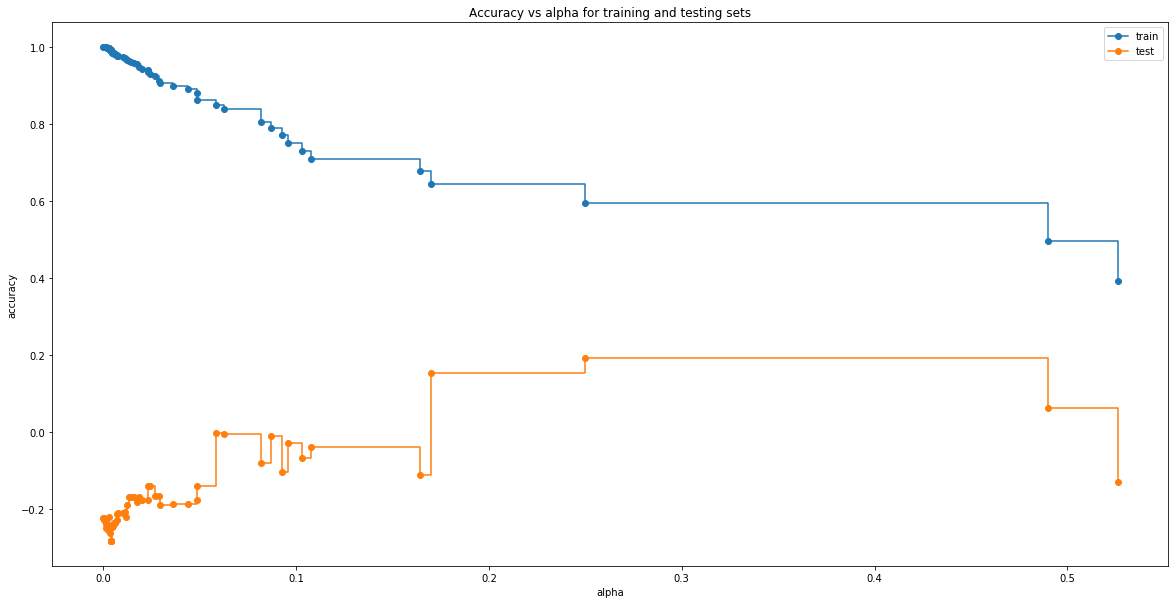

In [81]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

# Fit

In [82]:
clf = DecisionTreeRegressor(random_state=0,ccp_alpha=0.45)

clf.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.45, random_state=0)

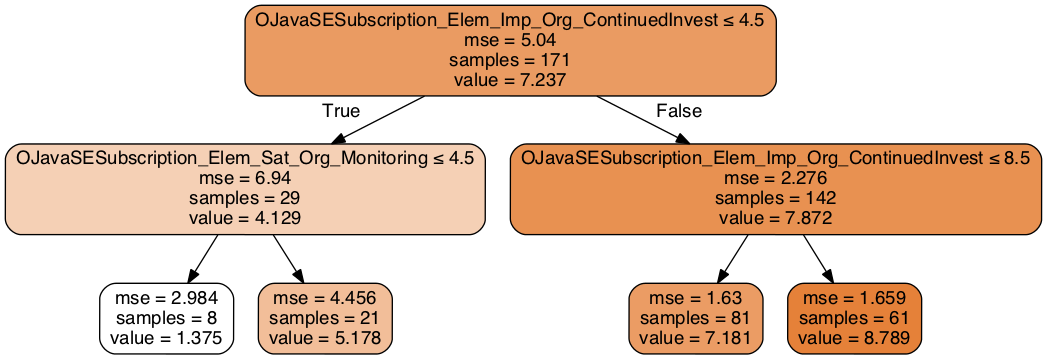

In [83]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               feature_names = X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [84]:
response

'OJavaSESubscription_Elem_Sat_Org_ContinuedInvest'

# create single Sat variable

In [191]:

y0_list = ['Sat_Org_EclipseIDE',
 'Sat_Org_IntelliJIDE',
 'Sat_Org_JDeveloper',
 'Sat_Org_NetBeansIDE',
 'Sat_Org_RationalAppDev',
 'Sat_Org_VisualStudio',
 'Sat_Org_Other']
y1_list = ['Sat_Org_JavaSEAMC',
 'Sat_Org_JavaSEAMC_UsageLog',
 'Sat_Org_JavaSEDepRuleSet',
 'Sat_Org_JavaSEMSICustTools',
 'Sat_Org_JavaSEFlightRec']
y2_list = ['OJavaSESubscription_Elem_Sat_Org_ContinuedInvest',
 'OJavaSESubscription_Elem_Sat_Org_PatchesOlderV',
 'OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates',
 'OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates',
 'OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools',
 'OJavaSESubscription_Elem_Sat_Org_Monitoring',
 'OJavaSESubscription_Elem_Sat_Org_MyOSupport',
 'OJavaSESubscription_Elem_Sat_Org_AccessCloud',
 'OJavaSESubscription_Elem_Sat_Org_FlexLicensing',
 'OJavaSESubscription_Elem_Sat_Org_LegacyJava',
 'OJavaSESubscription_Elem_Sat_Org_Other']
y3_list = ['OJavaSESubscription_Attr_Sat_CommMethods',
 'OJavaSESubscription_Attr_Sat_PhoneSupport',
 'OJavaSESubscription_Attr_Sat_SSKnowledge',
 'OJavaSESubscription_Attr_Sat_CoNeedsUnd',
 'OJavaSESubscription_Attr_Sat_TrainingQual',
 'OJavaSESubscription_Attr_Sat_RepsonseTime']

In [192]:
y1_var = mod_df[y1_list].sum(axis=1,skipna=True)
y2_var = mod_df[y2_list].sum(axis=1,skipna=True)
y3_var = mod_df[y3_list].sum(axis=1,skipna=True)

y23_var = mod_df[y2_list+y3_list].sum(axis=1,skipna=True)
y123_var = mod_df[y1_list + y2_list+y3_list].sum(axis=1,skipna=True)
# y23_var = mod_df[y2_list+y3_list].mean(axis=1,skipna=True)

# create single Use/Imp variable

In [322]:
x0_list = ['Use_Org_EclipseIDE',
 'Use_Org_IntelliJIDE',
 'Use_Org_JDeveloper',
 'Use_Org_NetBeansIDE',
 'Use_Org_RationalAppDev',
 'Use_Org_VisualStudio',
 'Use_Org_Other']

x1_list = ['Use_Org_JavaSEAMC',
 'Use_Org_JavaSEAMC_UsageLog',
 'Use_Org_JavaSEDepRuleSet',
 'Use_Org_JavaSEMSICustTools',
 'Use_Org_JavaSEFlightRec']
x2_list = ['OJavaSESubscription_Elem_Imp_Org_ContinuedInvest',
 'OJavaSESubscription_Elem_Imp_Org_PatchesOlderV',
 'OJavaSESubscription_Elem_Imp_Org_JavaWebStartUpdates',
 'OJavaSESubscription_Elem_Imp_Org_DesktopManageUpdates',
 'OJavaSESubscription_Elem_Imp_Org_AutoUpdateTools',
 'OJavaSESubscription_Elem_Imp_Org_Monitoring',
 'OJavaSESubscription_Elem_Imp_Org_MyOSupport',
 'OJavaSESubscription_Elem_Imp_Org_AccessCloud',
 'OJavaSESubscription_Elem_Imp_Org_FlexLicensing',
 'OJavaSESubscription_Elem_Imp_Org_LegacyJava',
 'OJavaSESubscription_Elem_Imp_Org_Other']
x3_list = ['OJavaSESubscription_Attr_Imp_CommMethods',
 'OJavaSESubscription_Attr_Imp_PhoneSupport',
 'OJavaSESubscription_Attr_Imp_SSKnowledge',
 'OJavaSESubscription_Attr_Imp_CoNeedsUnd',
 'OJavaSESubscription_Attr_Imp_TrainingQual',
 'OJavaSESubscription_Attr_Imp_RepsonseTime']

In [204]:
x0_var = mod_df[x0_list].sum(axis=1)
x1_var = mod_df[x1_list].sum(axis=1)
x2_var = mod_df[x2_list].sum(axis=1)
x3_var = mod_df[x3_list].sum(axis=1)

In [198]:
# determine optimal ccp_alpha
predictors = catg_dummy_list + cont_dummy_list + dummy0_dummy_list
response = y123_var

X = mod_df[predictors].drop(y1_list, axis=1).drop(y2_list, axis=1).drop(y3_list, axis=1)#.drop(x3_list, axis=1)
# X['OJavaSESubscription_Attr_*'] = pd.Series(x3_var, index=X.index)
y = response #mod_df[response]

X = X.fillna(X.mean())
y = y.fillna(y.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

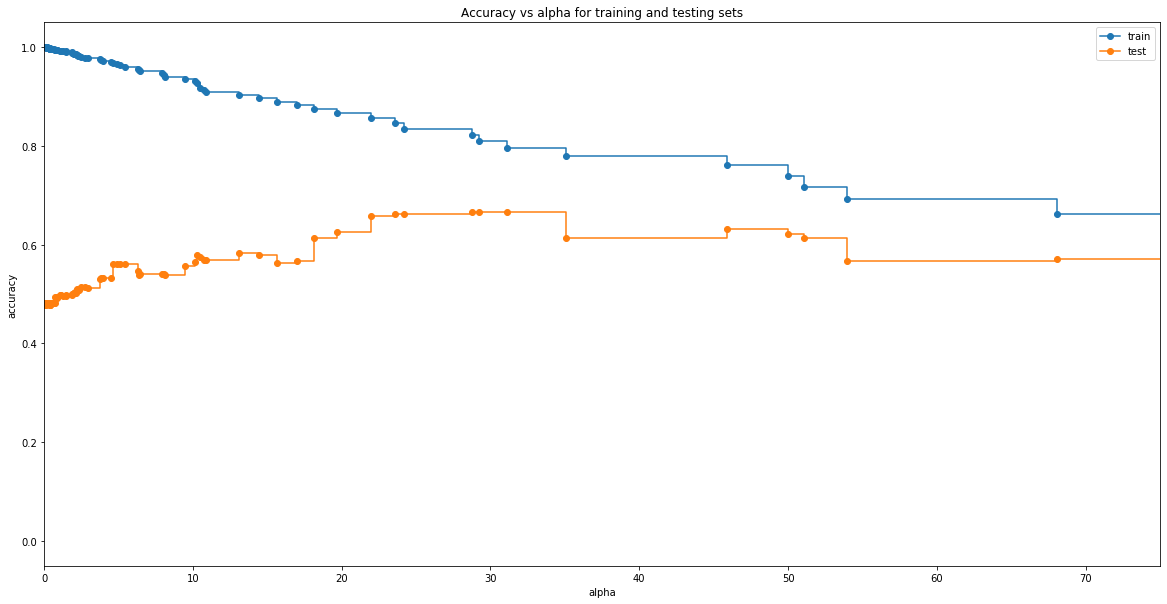

In [194]:
clf = DecisionTreeRegressor(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()

ax.set_xlim([0,75])

ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [195]:
clf = DecisionTreeRegressor(random_state=0,ccp_alpha=33)

clf.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=33, random_state=0)

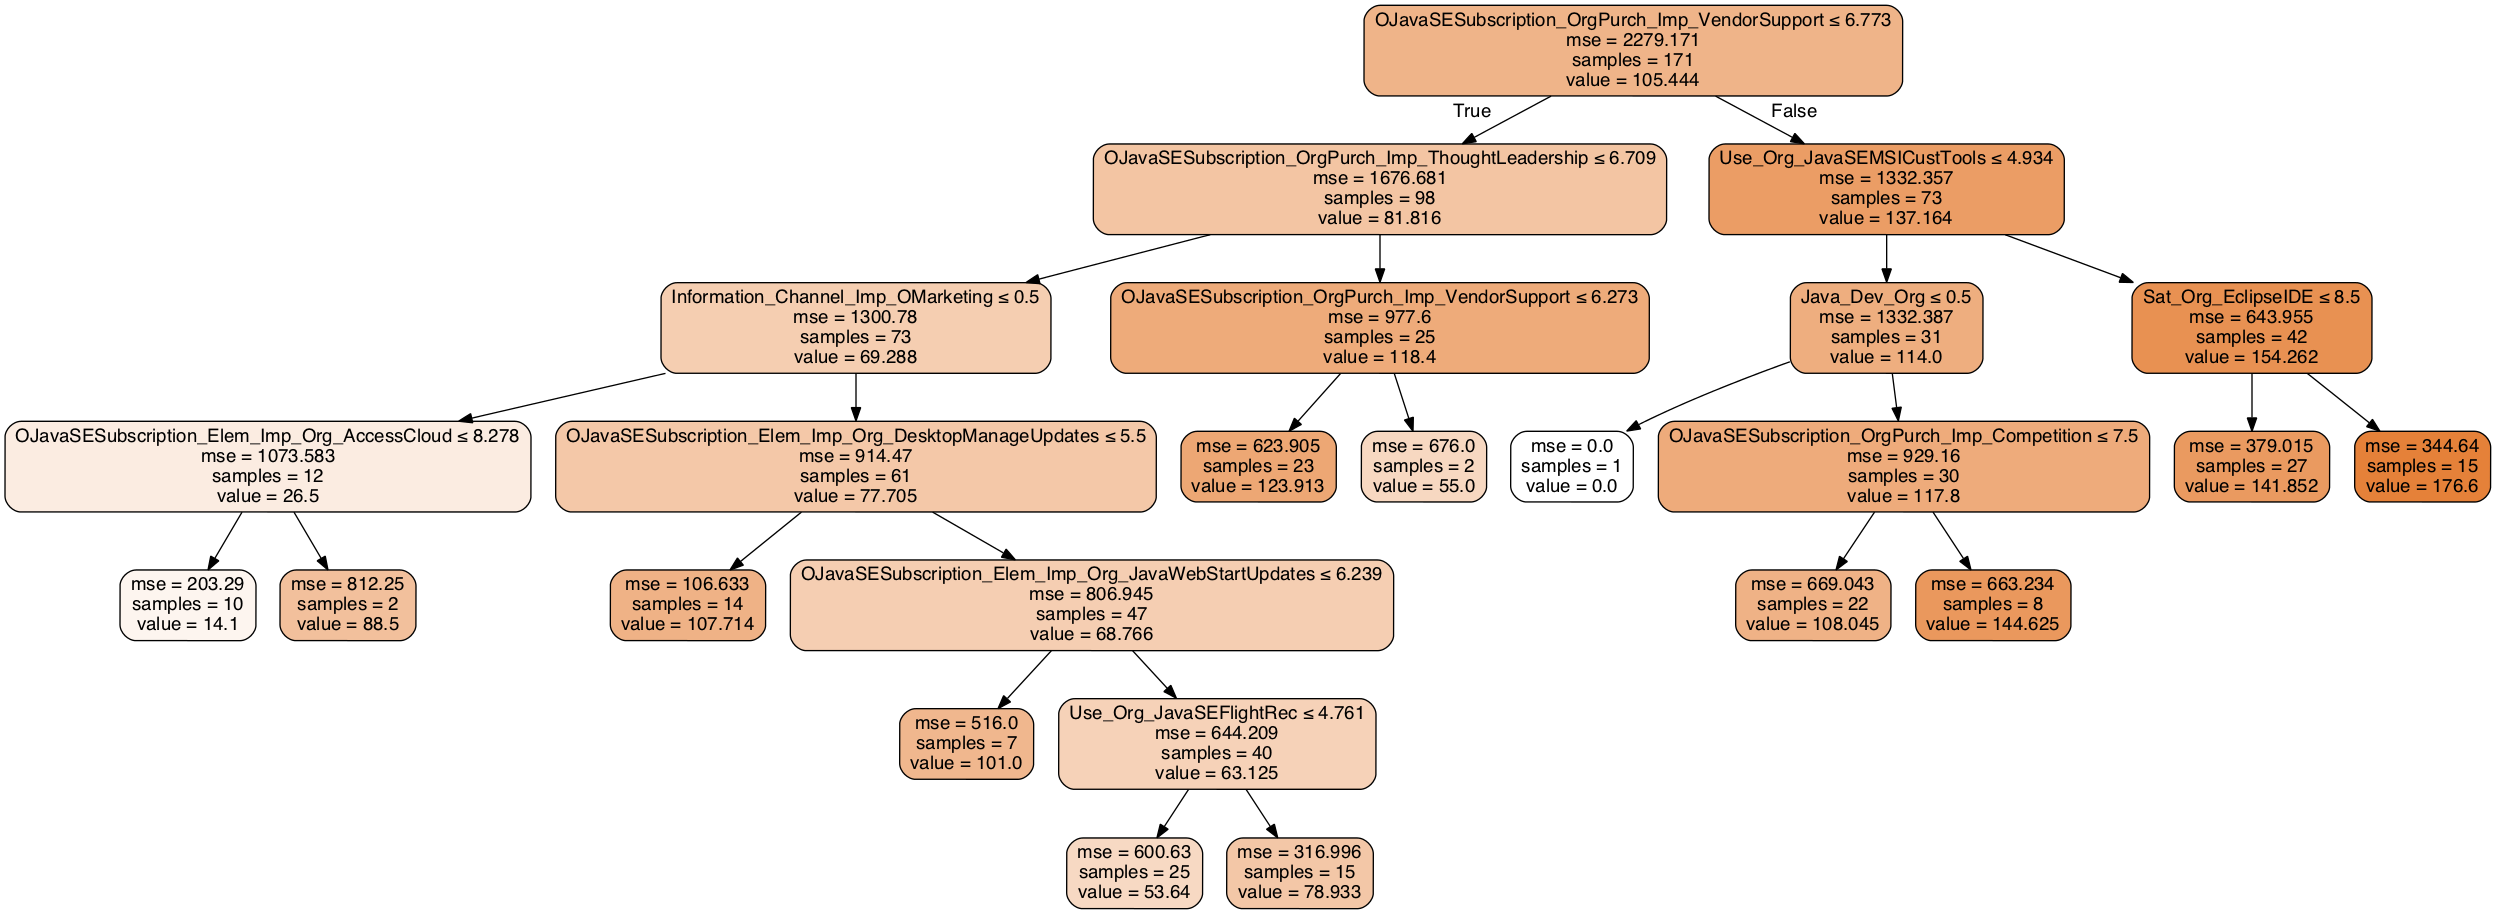

In [196]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               feature_names = X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [197]:
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.6660664140553711

# Create pipeline for regressing one (or more) vars are a time

In [ ]:
# Required data
mod_df = pd.read_csv('../data/output/mod_df.csv')  
catg_dummy_list = open('../data/output/catg_dummy_list.csv').read().splitlines()
cont_dummy_list = open('../data/output/cont_dummy_list.csv').read().splitlines()
dummy0_dummy_list = open('../data/output/dummy0_dummy_list.csv').read().splitlines()
exlc_dummy_list = open('../data/output/exlc_dummy_list.csv').read().splitlines()


y0_list = ['Sat_Org_EclipseIDE',
 'Sat_Org_IntelliJIDE',
 'Sat_Org_JDeveloper',
 'Sat_Org_NetBeansIDE',
 'Sat_Org_RationalAppDev',
 'Sat_Org_VisualStudio',
 'Sat_Org_Other']
y1_list = ['Sat_Org_JavaSEAMC',
 'Sat_Org_JavaSEAMC_UsageLog',
 'Sat_Org_JavaSEDepRuleSet',
 'Sat_Org_JavaSEMSICustTools',
 'Sat_Org_JavaSEFlightRec']
y2_list = ['OJavaSESubscription_Elem_Sat_Org_ContinuedInvest',
 'OJavaSESubscription_Elem_Sat_Org_PatchesOlderV',
 'OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates',
 'OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates',
 'OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools',
 'OJavaSESubscription_Elem_Sat_Org_Monitoring',
 'OJavaSESubscription_Elem_Sat_Org_MyOSupport',
 'OJavaSESubscription_Elem_Sat_Org_AccessCloud',
 'OJavaSESubscription_Elem_Sat_Org_FlexLicensing',
 'OJavaSESubscription_Elem_Sat_Org_LegacyJava',
 'OJavaSESubscription_Elem_Sat_Org_Other']
y3_list = ['OJavaSESubscription_Attr_Sat_CommMethods',
 'OJavaSESubscription_Attr_Sat_PhoneSupport',
 'OJavaSESubscription_Attr_Sat_SSKnowledge',
 'OJavaSESubscription_Attr_Sat_CoNeedsUnd',
 'OJavaSESubscription_Attr_Sat_TrainingQual',
 'OJavaSESubscription_Attr_Sat_RepsonseTime']

In [472]:
# def dtree_pipe (mod_df = mod_df, 
#                catg_dummy_list = catg_dummy_list,
#                cont_dummy_list = cont_dummy_list,
#                dummy0_dummy_list = dummy0_dummy_list,
#                exlc_dummy_list = exlc_dummy_list,
#                y_list = y1_list + y2_list + y3_list, # list of response variables, if len()>1, these will be summed or meaned
#                X_list = catg_dummy_list + cont_dummy_list + dummy0_dummy_list, 
#                X_drop = None, # list of additional predictors to drop 
#                y_funct = 'mean', # either None, 'sum' or 'mean'. Must be one of non-None if len(y_list)>1
#                vis_filename = '../data/output/dtree.png',
#                ccpa_filename = '../data/output/ccpa.png'):

#     if any(isinstance(el, list) for el in y_list): # flatten list if it's nested
#         y_list = [item for sublist in y_list for item in sublist]
#     if any(isinstance(el, list) for el in X_drop): # flatten list if it's nested
#         X_drop = [item for sublist in X_drop for item in sublist]
#     if isinstance(X_drop, tuple): # if tuple, convert to a list
#         X_drop = list(X_drop)
#     print(X_drop)

#     X = mod_df.drop(y_list, axis=1)[X_list].drop(X_drop, axis=1)
#     if y_funct == 'sum':
#         y = mod_df[y_list].sum(axis=1,skipna=True)
#     elif y_funct == 'mean':
#         y = mod_df[y_list].mean(axis=1,skipna=True)
#     else:
#         y = mod_df[y_list]
        
    
#     y_na = y.isna().sum()/len(y)
    

#     X = X.fillna(X.mean())
#     y = y.fillna(y.mean())
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
#     # find optimal ccp_alpha
#     clf = DecisionTreeRegressor(random_state=0)
#     path = clf.cost_complexity_pruning_path(X_train, y_train)
#     ccp_alphas, impurities = path.ccp_alphas, path.impurities

#     clfs = []
#     for ccp_alpha in ccp_alphas:
#         clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
#         clf.fit(X_train, y_train)
#         clfs.append(clf)

#     node_counts = [clf.tree_.node_count for clf in clfs]
#     depth = [clf.tree_.max_depth for clf in clfs]

#     path = clf.cost_complexity_pruning_path(X_train, y_train)
#     ccp_alphas, impurities = path.ccp_alphas, path.impurities

#     train_scores = [clf.score(X_train, y_train) for clf in clfs]
#     test_scores = [clf.score(X_test, y_test) for clf in clfs]
    
#     fig, ax = plt.subplots()
#     ax.set_xlabel("alpha")
#     ax.set_ylabel("accuracy")
#     ax.set_title("Accuracy vs alpha for training and testing sets")
#     ax.plot(ccp_alphas, train_scores, marker='o', label="train",
#             drawstyle="steps-post")
#     ax.plot(ccp_alphas, test_scores, marker='o', label="test",
#             drawstyle="steps-post")
#     ax.legend()
#     plt.savefig(ccpa_filename)

#     ccp_a_df = pd.DataFrame( {'ccp_alphas':ccp_alphas,
#                               'train_scores':train_scores,
#                               'test_scores':test_scores})
#     ccp_a_df['diff'] = ccp_a_df.train_scores - ccp_a_df.test_scores
#     ccp_alpha = ccp_a_df['ccp_alphas'].iloc[ccp_a_df['test_scores'].idxmax()]
    
#     clf = DecisionTreeRegressor(random_state=0,ccp_alpha=ccp_alpha)
#     clf.fit(X_train,y_train)
    
#     dot_data = StringIO()
#     export_graphviz(clf, out_file=dot_data,  
#                     filled=True, rounded=True,
#                     special_characters=True,
#                    feature_names = X_train.columns)
#     graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#     pydotplus.graph_from_dot_data(dot_data.getvalue()).write_png(vis_filename)
    
#     y_pred = clf.predict(X_test)
#     score = clf.score(X_test, y_test)
    
#     return(ccp_alpha,clf,score, y_na, ', '.join(X_drop) )


                

In [221]:
ccp_alpha, clf, score = dtree_pipe()

<IPython.core.display.Image object>


['OJavaSESubscription_Attr_Sat_RepsonseTime',
 1.084648473131622,
 DecisionTreeRegressor(ccp_alpha=1.084648473131622, random_state=0),
 -0.0007937906059265476]

# Pipe through all individual Y-candidates

In [263]:
y_list_list = y1_list + y2_list + y3_list

results = []
for y_list in y_list_list:
    print("../data/output/dtree_%s.png" % (y_list))
    
    ccp_alpha, clf, score  = dtree_pipe (
                   mod_df = mod_df, 
                   y_list = y_list, # list of response variables, if len()>1, these will be summed or meaned
                   X_list = catg_dummy_list + cont_dummy_list + dummy0_dummy_list, 
                   y_funct = None, # either None, 'sum' or 'mean'. Must be one of non-None if len(y_list)>1
                   vis_filename = "../data/output/dtree_%s.png" % (y_list),
                   ccpa_filename = "../data/output/ccpa_%s.png" % (y_list))
    
    results.append([y_list, ccp_alpha, clf, score])

ind_y_results = pd.DataFrame(results, columns = ['var', 'ccp_alpha', 'clf', 'score'])
ind_y_results.to_csv('../data/output/ind_y_results.csv',index=False)

# Run through grouped results

../data/output/dtree_y123_sum.png
../data/output/dtree_y12_sum.png
../data/output/dtree_y13_sum.png
../data/output/dtree_y23_sum.png
../data/output/dtree_y1_sum.png
../data/output/dtree_y2_sum.png
../data/output/dtree_y3_sum.png


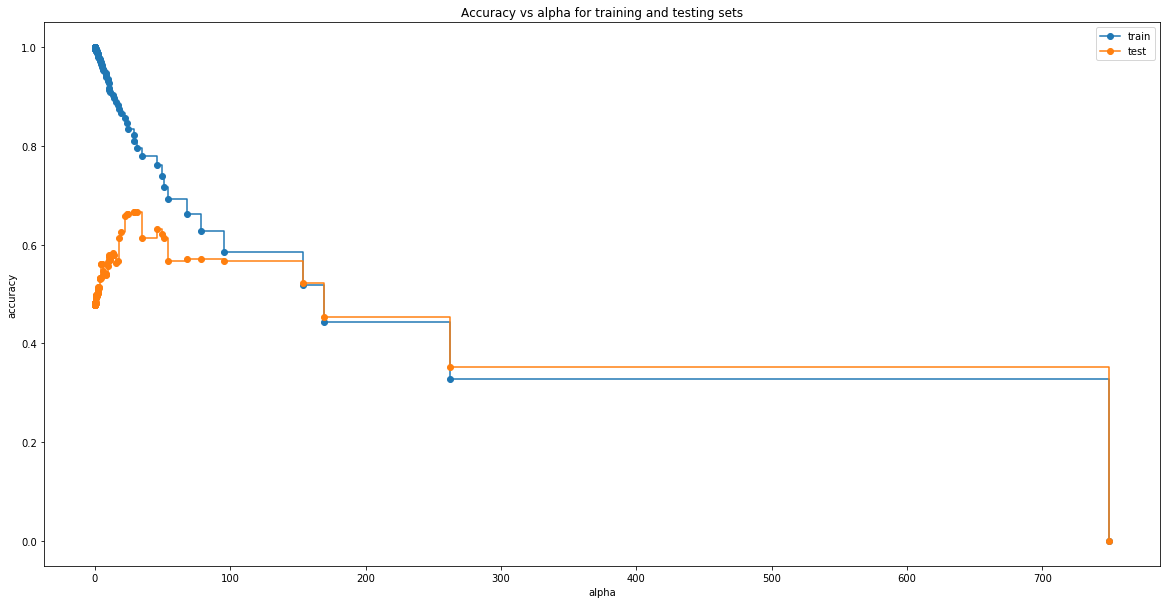

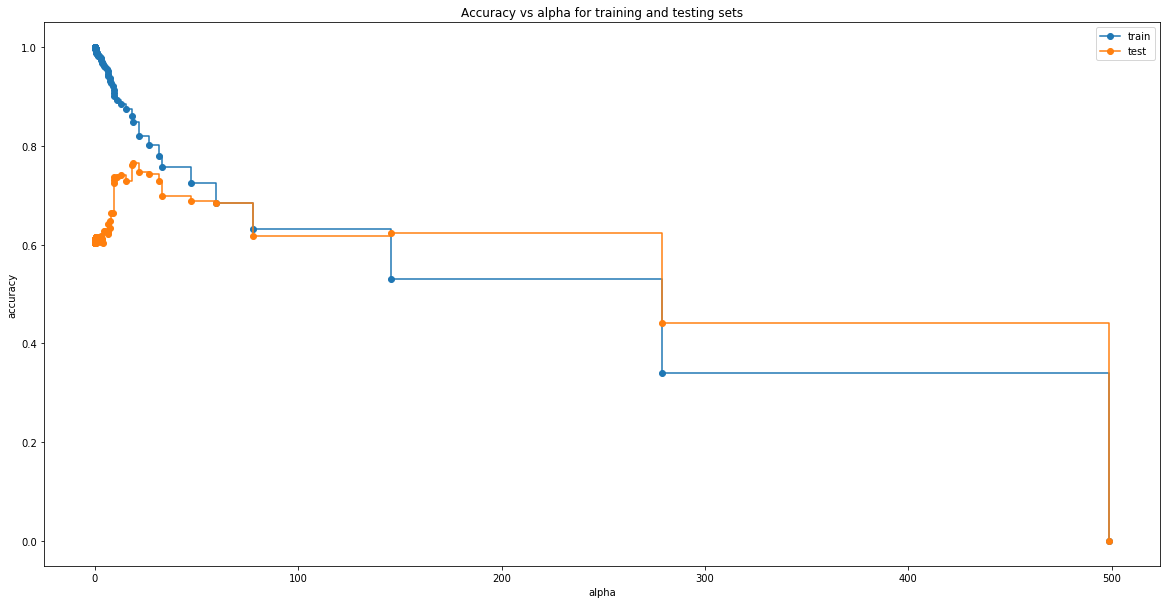

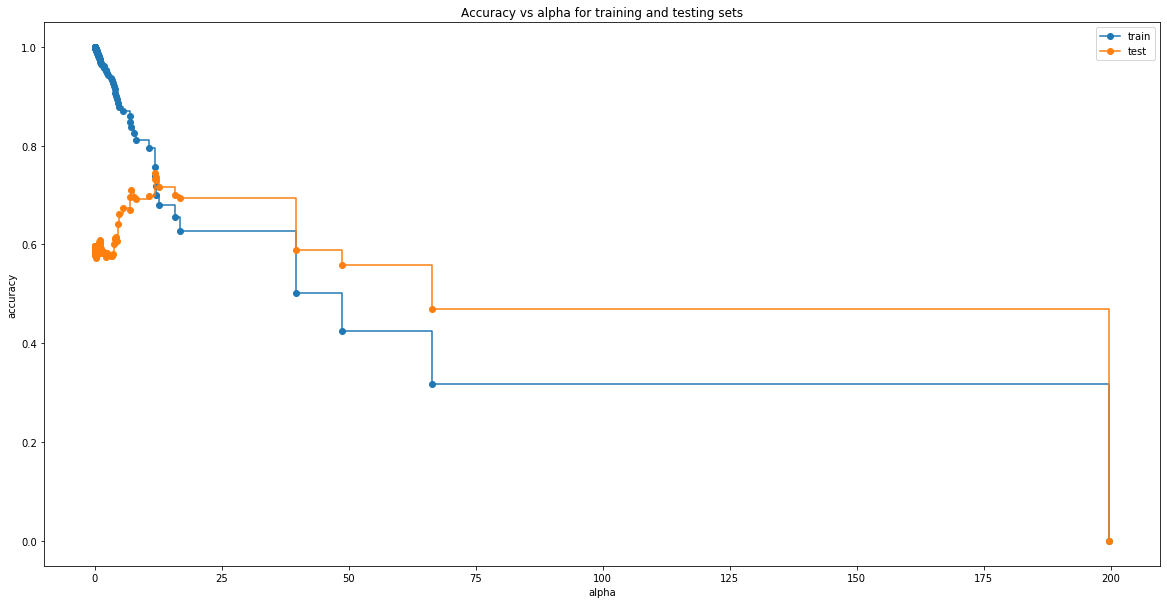

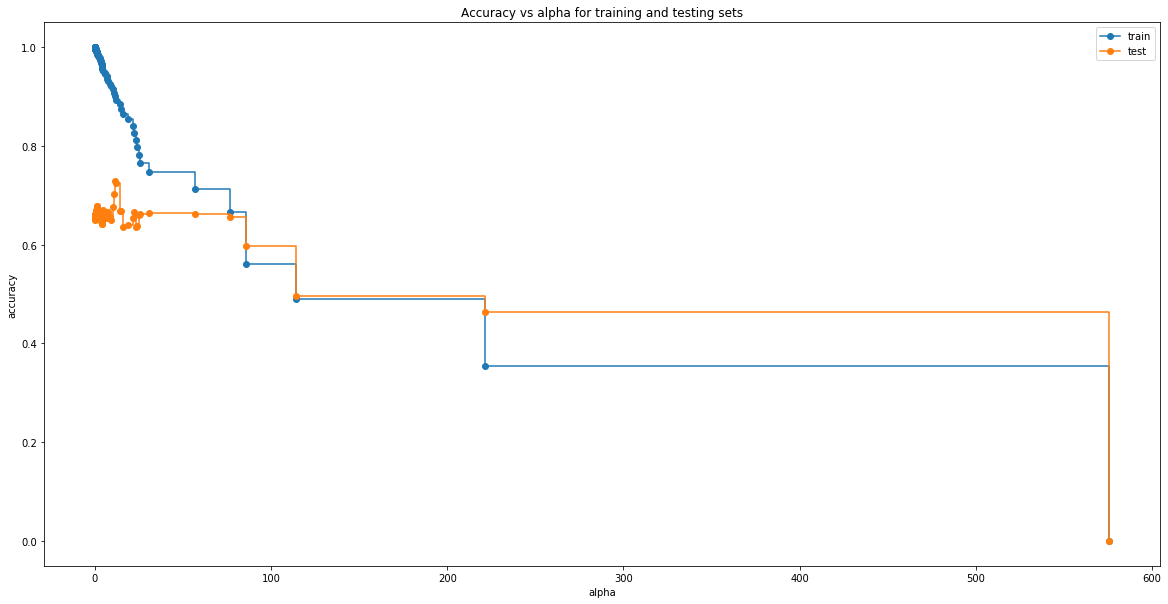

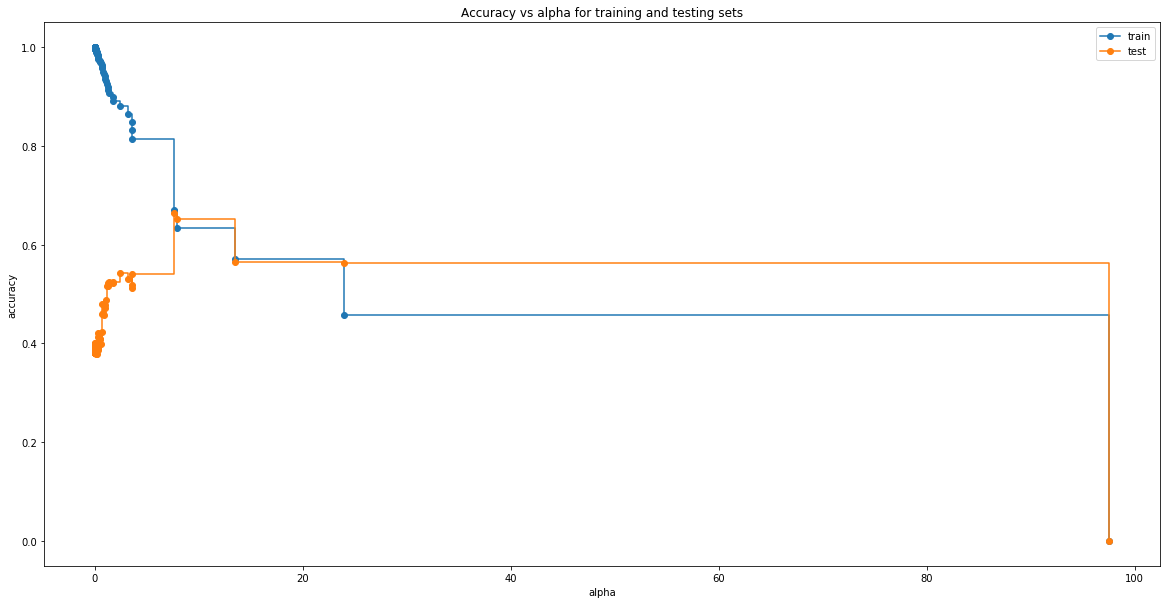

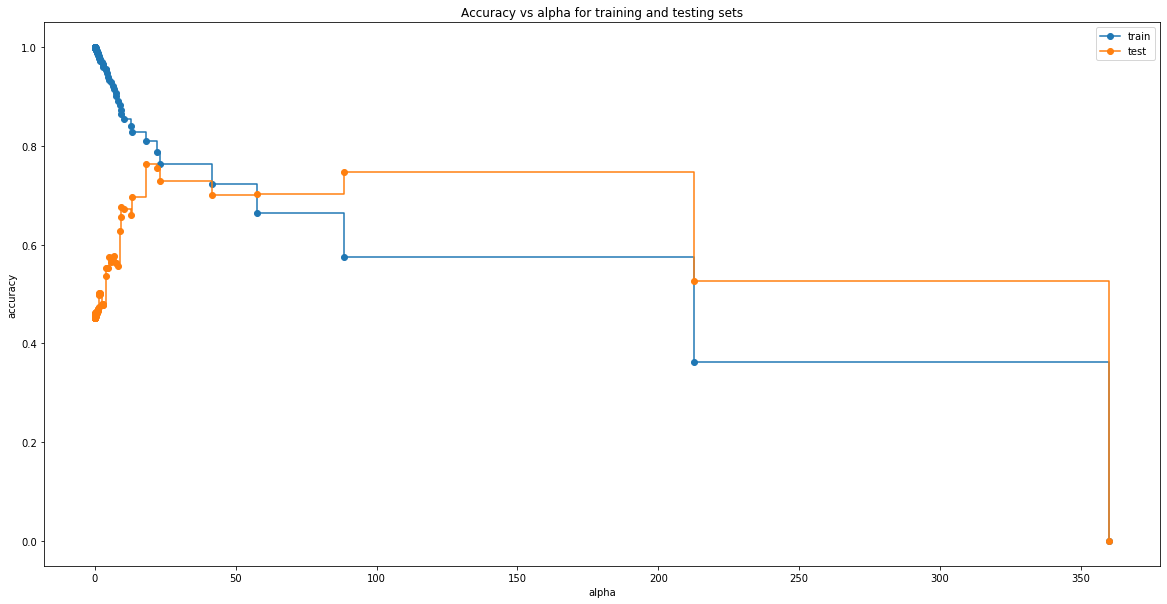

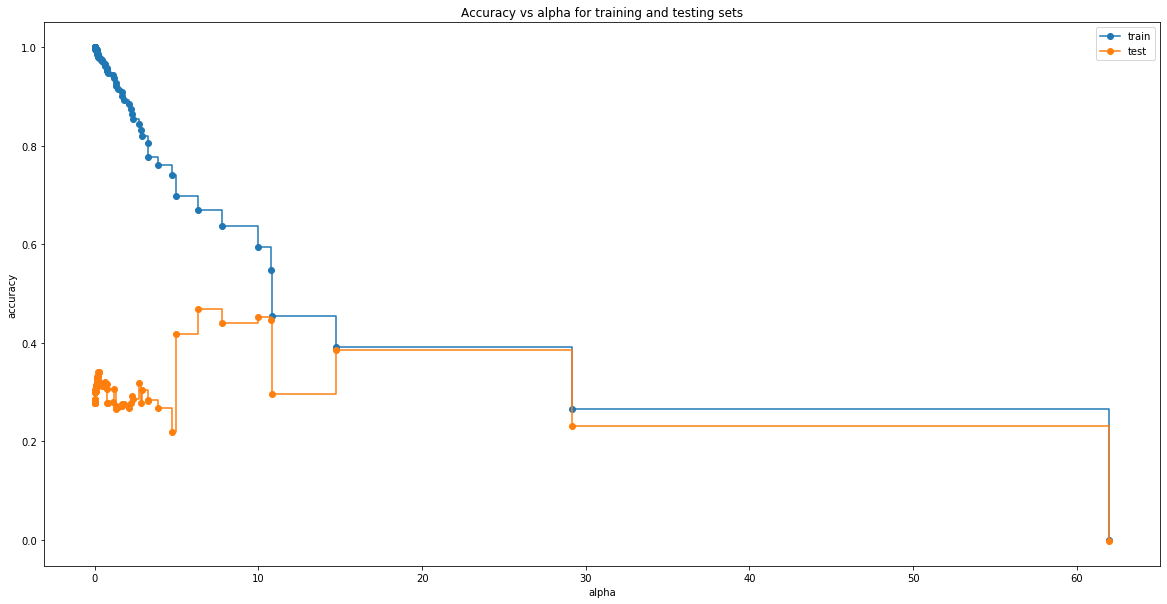

In [286]:
y_list_list = [[y1_list + y2_list + y3_list], 
              [y1_list + y2_list], 
              [y1_list + y3_list], 
              [y2_list + y3_list],
               y1_list, 
               y2_list,
               y3_list]

y_list_names = ['y123', 'y12','y13','y23','y1','y2','y3']

results = []
i=0
for y_list in y_list_list:
    y_funct = 'sum'
    vis_filename = "../data/output/dtree_%s_%s.png" % (y_list_names[i],y_funct)
    ccpa_filename = "../data/output/ccpa_%s_%s.png" % (y_list_names[i],y_funct)
    print(vis_filename)
    
    ccp_alpha, clf, score  = dtree_pipe (
                   mod_df = mod_df, 
                   y_list = y_list, # list of response variables, if len()>1, these will be summed or meaned
                   X_list = catg_dummy_list + cont_dummy_list + dummy0_dummy_list, 
                   y_funct = y_funct, # either None, 'sum' or 'mean'. Must be one of non-None if len(y_list)>1
                   vis_filename =vis_filename,
                   ccpa_filename = ccpa_filename)
    
    results.append([y_list_names[i], ccp_alpha, clf, score])
    i = i+1

grp_y_sum_results = pd.DataFrame(results, columns = ['var', 'ccp_alpha', 'clf', 'score'])
grp_y_sum_results.to_csv('../data/output/grp_y_sum_results.csv',index=False)

../data/output/dtree_y123_mean.png
../data/output/dtree_y12_mean.png
../data/output/dtree_y13_mean.png
../data/output/dtree_y23_mean.png
../data/output/dtree_y1_mean.png
../data/output/dtree_y2_mean.png
../data/output/dtree_y3_mean.png


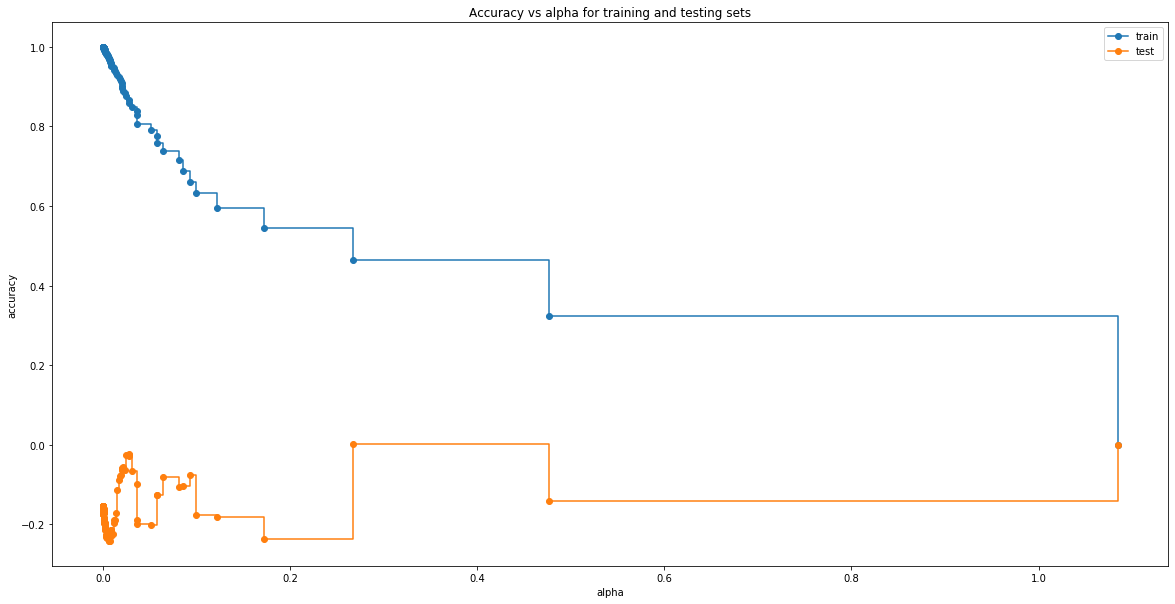

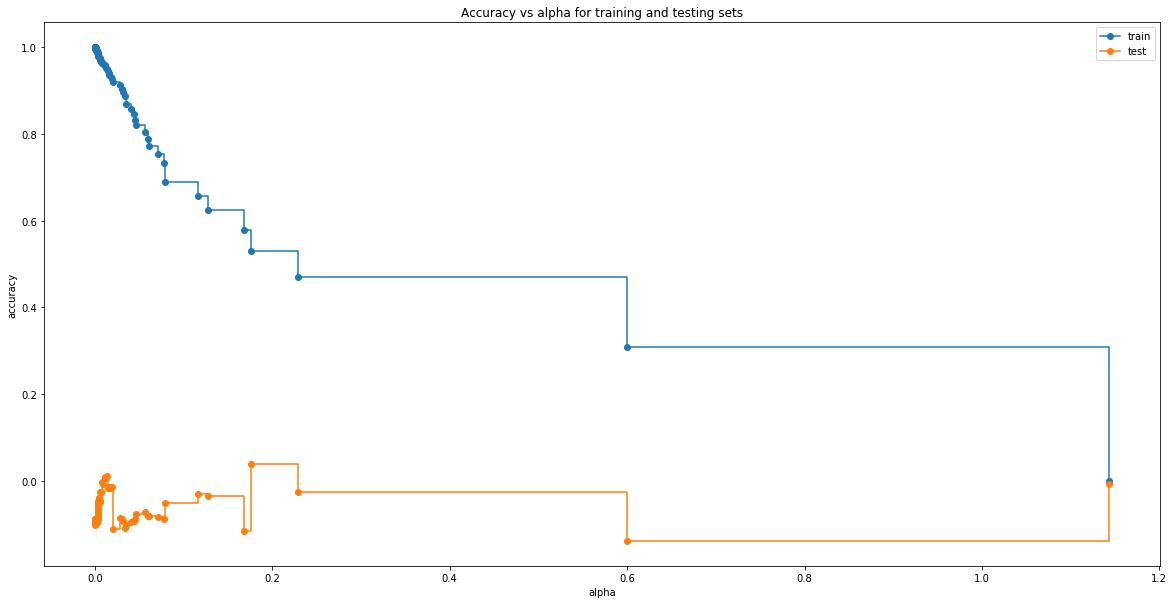

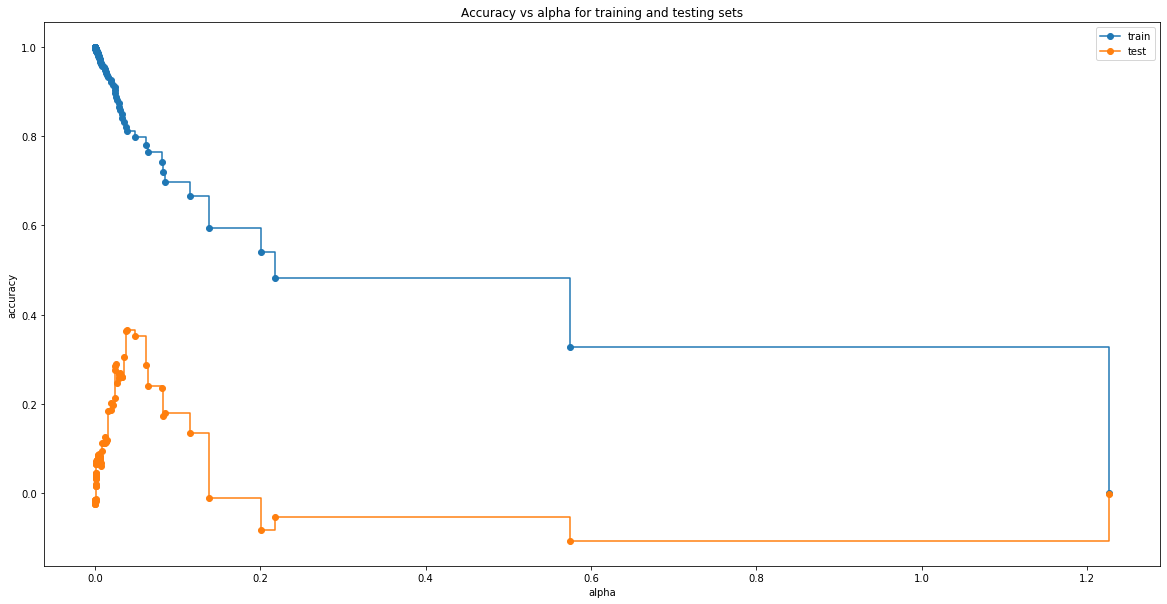

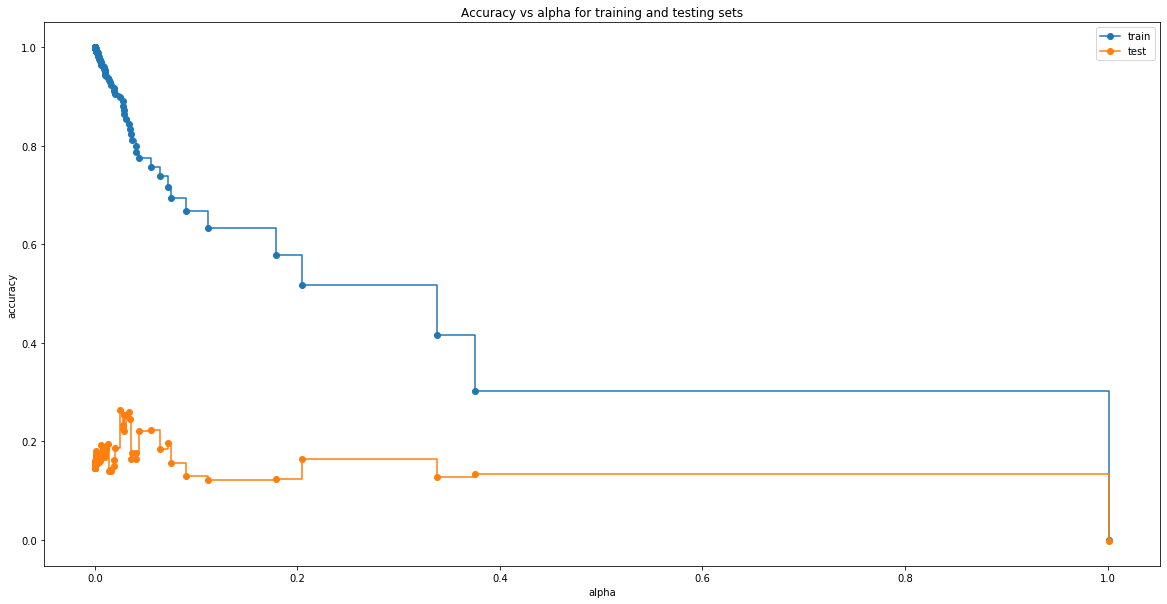

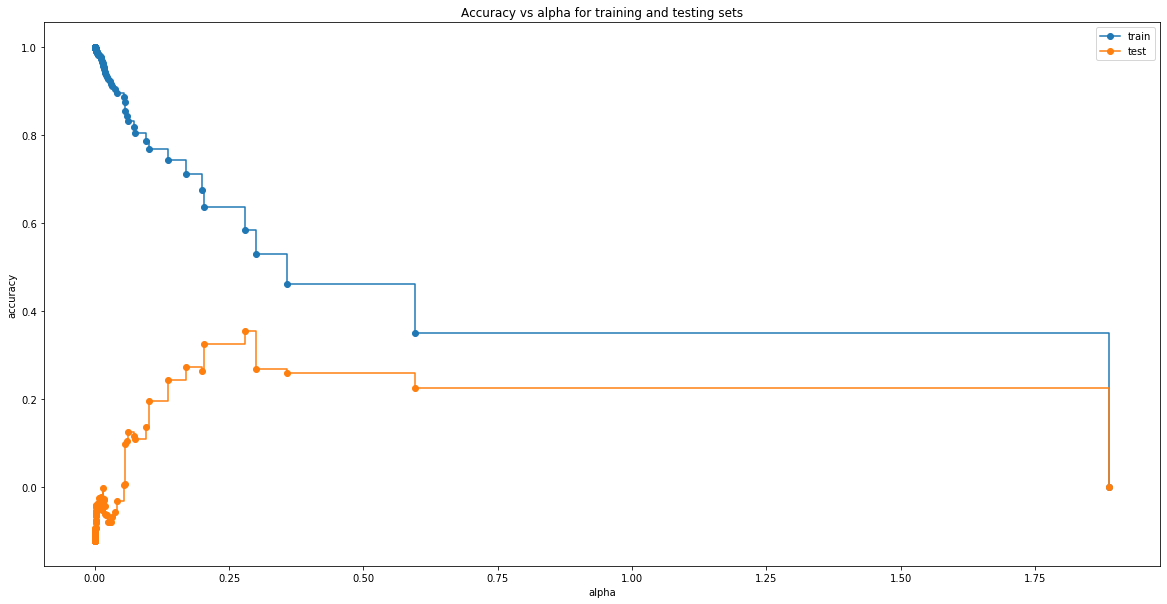

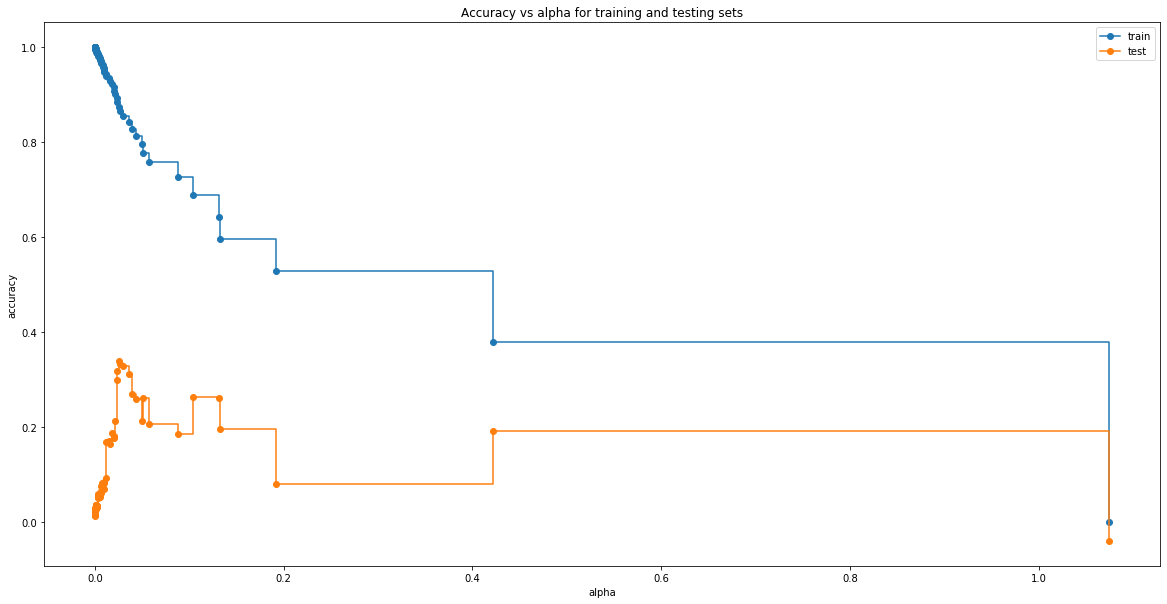

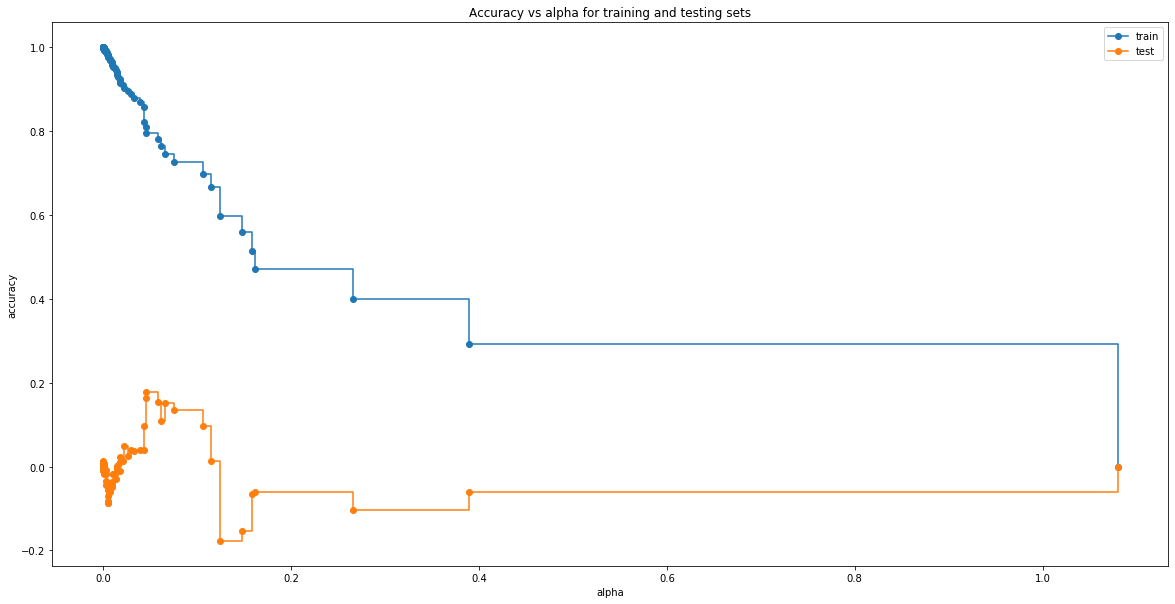

In [285]:
y_list_list = [[y1_list + y2_list + y3_list], 
              [y1_list + y2_list], 
              [y1_list + y3_list], 
              [y2_list + y3_list],
               y1_list, 
               y2_list,
               y3_list]

y_list_names = ['y123', 'y12','y13','y23','y1','y2','y3']

results = []
i=0
for y_list in y_list_list:
    y_funct = 'mean'
    vis_filename = "../data/output/dtree_%s_%s.png" % (y_list_names[i],y_funct)
    ccpa_filename = "../data/output/ccpa_%s_%s.png" % (y_list_names[i],y_funct)
    print(vis_filename)
    
    ccp_alpha, clf, score  = dtree_pipe (
                   mod_df = mod_df, 
                   y_list = y_list, # list of response variables, if len()>1, these will be summed or meaned
                   X_list = catg_dummy_list + cont_dummy_list + dummy0_dummy_list, 
                   y_funct = y_funct, # either None, 'sum' or 'mean'. Must be one of non-None if len(y_list)>1
                   vis_filename =vis_filename,
                   ccpa_filename = ccpa_filename)
    
    results.append([y_list_names[i], ccp_alpha, clf, score])
    i = i+1

grp_y_mean_results = pd.DataFrame(results, columns = ['var', 'ccp_alpha', 'clf', 'score'])
grp_y_mean_results.to_csv('../data/output/grp_y_mean_results.csv',index=False)

In [283]:
print(y_list_names)
[len([item for sublist in y_list for item in sublist]) for y_list in y_list_list]

['y123', 'y12', 'y13', 'y23']


[22, 16, 11, 17]

# Examine results of pipeline runs

In [272]:
grp_y_mean_results = pd.read_csv('../data/output/grp_y_mean_results.csv')
grp_y_sum_results = pd.read_csv('../data/output/grp_y_sum_results.csv')
ind_y_results = pd.read_csv('../data/output/ind_y_results.csv')

In [278]:
ind_y_results.sort_values(['score'],ascending=False).head()

,var,ccp_alpha,clf,score
4,Sat_Org_JavaSEFlightRec,0.142206,"DecisionTreeRegressor(ccp_alpha=0.14220558327436783, random_state=0)",0.727234
15,OJavaSESubscription_Elem_Sat_Org_Other,0.147688,"DecisionTreeRegressor(ccp_alpha=0.1476875729268074, random_state=0)",0.660048
2,Sat_Org_JavaSEDepRuleSet,0.291098,"DecisionTreeRegressor(ccp_alpha=0.2910981156595191, random_state=0)",0.594890
12,OJavaSESubscription_Elem_Sat_Org_AccessCloud,0.257641,"DecisionTreeRegressor(ccp_alpha=0.2576405446449246, random_state=0)",0.415058
1,Sat_Org_JavaSEAMC_UsageLog,0.408695,"DecisionTreeRegressor(ccp_alpha=0.40869543343284387, random_state=0)",0.413002


In [287]:
grp_y_sum_results.sort_values(['score'],ascending=False).head()

,var,ccp_alpha,clf,score
1,y12,18.628924,"DecisionTreeRegressor(ccp_alpha=18.628923513134048, random_state=0)",0.765901
5,y2,18.166811,"DecisionTreeRegressor(ccp_alpha=18.16681061628436, random_state=0)",0.762853
2,y13,11.804448,"DecisionTreeRegressor(ccp_alpha=11.80444798865853, random_state=0)",0.743953
3,y23,11.306669,"DecisionTreeRegressor(ccp_alpha=11.306669451406314, random_state=0)",0.727879
0,y123,29.246688,"DecisionTreeRegressor(ccp_alpha=29.246688374977595, random_state=0)",0.666335


In [288]:
grp_y_mean_results.sort_values(['score'],ascending=False).head()

,var,ccp_alpha,clf,score
2,y13,0.038746,"DecisionTreeRegressor(ccp_alpha=0.03874633267893801, random_state=0)",0.365072
4,y1,0.279385,"DecisionTreeRegressor(ccp_alpha=0.27938471990125957, random_state=0)",0.354859
5,y2,0.025314,"DecisionTreeRegressor(ccp_alpha=0.02531355641291856, random_state=0)",0.339279
3,y23,0.024815,"DecisionTreeRegressor(ccp_alpha=0.02481542719883159, random_state=0)",0.263933
6,y3,0.045896,"DecisionTreeRegressor(ccp_alpha=0.04589571150097444, random_state=0)",0.177744


# Count number of non-missings in every notable response

In [299]:
X_train, X_test = train_test_split(mod_df, random_state=0)
print(X_train.shape[0])
print(X_test.shape[0])

171
57


In [305]:
print(X_train['Sat_Org_JavaSEFlightRec'].isna().sum()/X_train.shape[0])
print(X_test['Sat_Org_JavaSEFlightRec'].isna().sum()/X_test.shape[0])

0.3567251461988304
0.3157894736842105


In [306]:
print(X_train['OJavaSESubscription_Elem_Sat_Org_Other'].isna().sum()/X_train.shape[0])
print(X_test['OJavaSESubscription_Elem_Sat_Org_Other'].isna().sum()/X_test.shape[0])

0.9005847953216374
0.9122807017543859


In [312]:
print(X_train[y1_list + y2_list].sum(axis=1,skipna=True).isna().sum()/X_train.shape[0])
print(X_test[y1_list + y2_list].sum(axis=1,skipna=True).isna().sum()/X_test.shape[0])


0.0
0.0


In [315]:
print(X_train[y2_list].sum(axis=1,skipna=True).isna().sum()/X_train.shape[0])
print(X_test[y2_list].sum(axis=1,skipna=True).isna().sum()/X_test.shape[0])


0.0
0.0


In [316]:
print(X_train[y1_list + y3_list].sum(axis=1,skipna=True).isna().sum()/X_train.shape[0])
print(X_test[y1_list + y3_list].sum(axis=1,skipna=True).isna().sum()/X_test.shape[0])


0.0
0.0


In [317]:
print(X_train[y2_list + y3_list].sum(axis=1,skipna=True).isna().sum()/X_train.shape[0])
print(X_test[y2_list + y3_list].sum(axis=1,skipna=True).isna().sum()/X_test.shape[0])


0.0
0.0


In [318]:
print(X_train[y1_list + y2_list + y3_list].sum(axis=1,skipna=True).isna().sum()/X_train.shape[0])
print(X_test[y1_list + y2_list + y3_list].sum(axis=1,skipna=True).isna().sum()/X_test.shape[0])


0.0
0.0


# Weighted 

In [342]:
modw_df = mod_df.copy()
modw_df.shape

(228, 235)

In [330]:
mod_df[y0_list].head()

,Sat_Org_EclipseIDE,Sat_Org_IntelliJIDE,Sat_Org_JDeveloper,Sat_Org_NetBeansIDE,Sat_Org_RationalAppDev,Sat_Org_VisualStudio,Sat_Org_Other
0,9.0,10.0,NaN,NaN,NaN,NaN,NaN
1,10.0,NaN,NaN,10.0,NaN,10.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.0,10.0,NaN,NaN,NaN,NaN,NaN
4,9.0,10.0,NaN,NaN,NaN,7.0,10.0


In [331]:
mod_df[x0_list].head()

,Use_Org_EclipseIDE,Use_Org_IntelliJIDE,Use_Org_JDeveloper,Use_Org_NetBeansIDE,Use_Org_RationalAppDev,Use_Org_VisualStudio,Use_Org_Other
0,8.0,9.0,NaN,NaN,NaN,NaN,NaN
1,8.0,NaN,NaN,10.0,NaN,10.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,5.0,NaN,NaN,NaN,NaN,NaN
4,7.0,9.0,NaN,NaN,NaN,9.0,10.0


In [343]:
print(len(y0_list))
weighted_df_y0 = mod_df[y0_list] * mod_df[x0_list].values
weighted_df_y0.columns = [x+"_w" for x in weighted_df_y0.columns]
modw_df = modw_df.join(weighted_df_y0)
modw_df.shape

7


(228, 242)

In [344]:
print(len(y1_list))
weighted_df_y1 = mod_df[y1_list] * mod_df[x1_list].values
weighted_df_y1.columns = [x+"_w" for x in weighted_df_y1.columns]
modw_df = modw_df.join(weighted_df_y1)
modw_df.shape

5


(228, 247)

In [345]:
print(len(y2_list))
weighted_df_y2 = mod_df[y2_list] * mod_df[x2_list].values
weighted_df_y2.columns = [x+"_w" for x in weighted_df_y2.columns]
modw_df = modw_df.join(weighted_df_y2)
modw_df.shape

11


(228, 258)

In [346]:
print(len(y3_list))
weighted_df_y3 = mod_df[y3_list] * mod_df[x3_list].values
weighted_df_y3.columns = [x+"_w" for x in weighted_df_y3.columns]
modw_df = modw_df.join(weighted_df_y3)
modw_df.shape

6


(228, 264)

In [350]:
y0w_list = [x+"_w" for x in y0_list]
y1w_list = [x+"_w" for x in y1_list]
y2w_list = [x+"_w" for x in y2_list]
y3w_list = [x+"_w" for x in y3_list]

In [438]:
test = 
pd.DataFrame(test)


,0,1
0,Sat_Org_JavaSEAMC,Use_Org_JavaSEAMC
1,Sat_Org_JavaSEAMC_UsageLog,Use_Org_JavaSEAMC_UsageLog
2,Sat_Org_JavaSEDepRuleSet,Use_Org_JavaSEDepRuleSet
3,Sat_Org_JavaSEMSICustTools,Use_Org_JavaSEMSICustTools
4,Sat_Org_JavaSEFlightRec,Use_Org_JavaSEFlightRec
5,OJavaSESubscription_Elem_Sat_Org_ContinuedInvest,OJavaSESubscription_Elem_Imp_Org_ContinuedInvest
6,OJavaSESubscription_Elem_Sat_Org_PatchesOlderV,OJavaSESubscription_Elem_Imp_Org_PatchesOlderV
7,OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates,OJavaSESubscription_Elem_Imp_Org_JavaWebStartUpdates
8,OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates,OJavaSESubscription_Elem_Imp_Org_DesktopManageUpdates
9,OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools,OJavaSESubscription_Elem_Imp_Org_AutoUpdateTools


In [405]:
X_drop = test[0]
X_drop

('Sat_Org_JavaSEAMC', 'Use_Org_JavaSEAMC')

In [429]:

if isinstance(X_drop, tuple):
    testt = list(X_drop)
testt

['Sat_Org_JavaSEAMC', 'Use_Org_JavaSEAMC']

In [419]:
# any(isinstance(el, list) for el in X_drop)
    testt = [x for x in X_drop]
testt

['Sat_Org_JavaSEAMC', 'Use_Org_JavaSEAMC']

In [431]:
print(mod_df.shape)
print(mod_df.drop(testt, axis=1).shape) 

(228, 235)
(228, 233)


In [423]:
mod_df.head()

AttributeError: 'tuple' object has no attribute 'head'

In [420]:
print(X.drop(testt, axis=1).shape) 

KeyError: "['Sat_Org_JavaSEAMC'] not found in axis"

../data/output/dtree_Sat_Org_JavaSEAMC_w.png
['Sat_Org_JavaSEAMC', 'Use_Org_JavaSEAMC']
../data/output/dtree_Sat_Org_JavaSEAMC_UsageLog_w.png
['Sat_Org_JavaSEAMC_UsageLog', 'Use_Org_JavaSEAMC_UsageLog']
../data/output/dtree_Sat_Org_JavaSEDepRuleSet_w.png
['Sat_Org_JavaSEDepRuleSet', 'Use_Org_JavaSEDepRuleSet']
../data/output/dtree_Sat_Org_JavaSEMSICustTools_w.png
['Sat_Org_JavaSEMSICustTools', 'Use_Org_JavaSEMSICustTools']
../data/output/dtree_Sat_Org_JavaSEFlightRec_w.png
['Sat_Org_JavaSEFlightRec', 'Use_Org_JavaSEFlightRec']
../data/output/dtree_OJavaSESubscription_Elem_Sat_Org_ContinuedInvest_w.png
['OJavaSESubscription_Elem_Sat_Org_ContinuedInvest', 'OJavaSESubscription_Elem_Imp_Org_ContinuedInvest']
../data/output/dtree_OJavaSESubscription_Elem_Sat_Org_PatchesOlderV_w.png
['OJavaSESubscription_Elem_Sat_Org_PatchesOlderV', 'OJavaSESubscription_Elem_Imp_Org_PatchesOlderV']
../data/output/dtree_OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates_w.png
['OJavaSESubscription_Elem_Sat_

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


../data/output/dtree_OJavaSESubscription_Attr_Sat_RepsonseTime_w.png
['OJavaSESubscription_Attr_Sat_RepsonseTime', 'OJavaSESubscription_Attr_Imp_RepsonseTime']


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


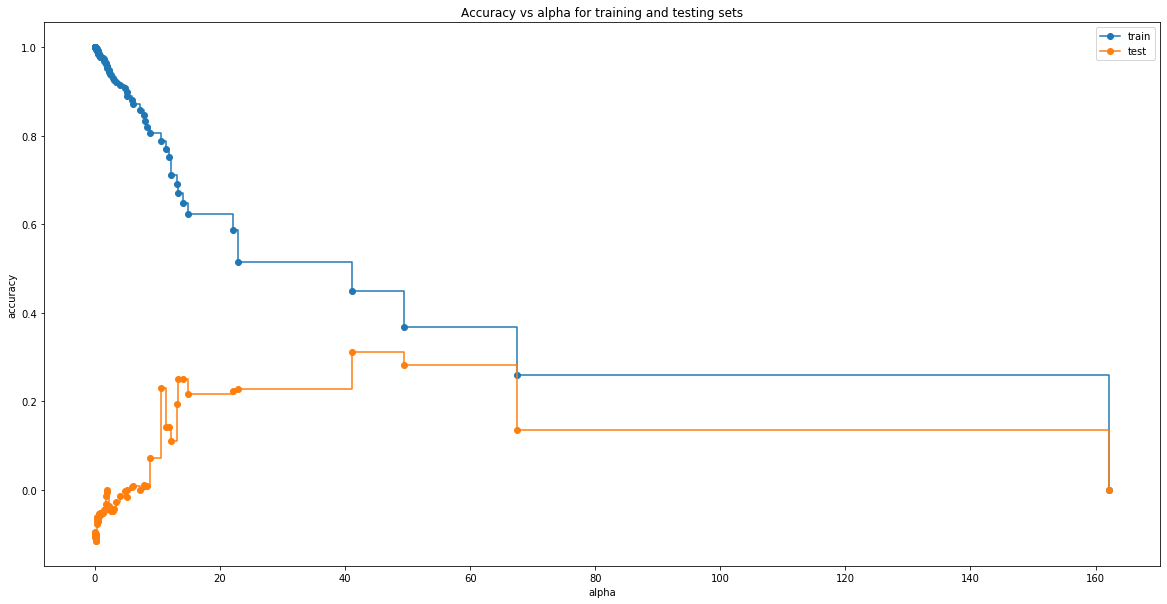

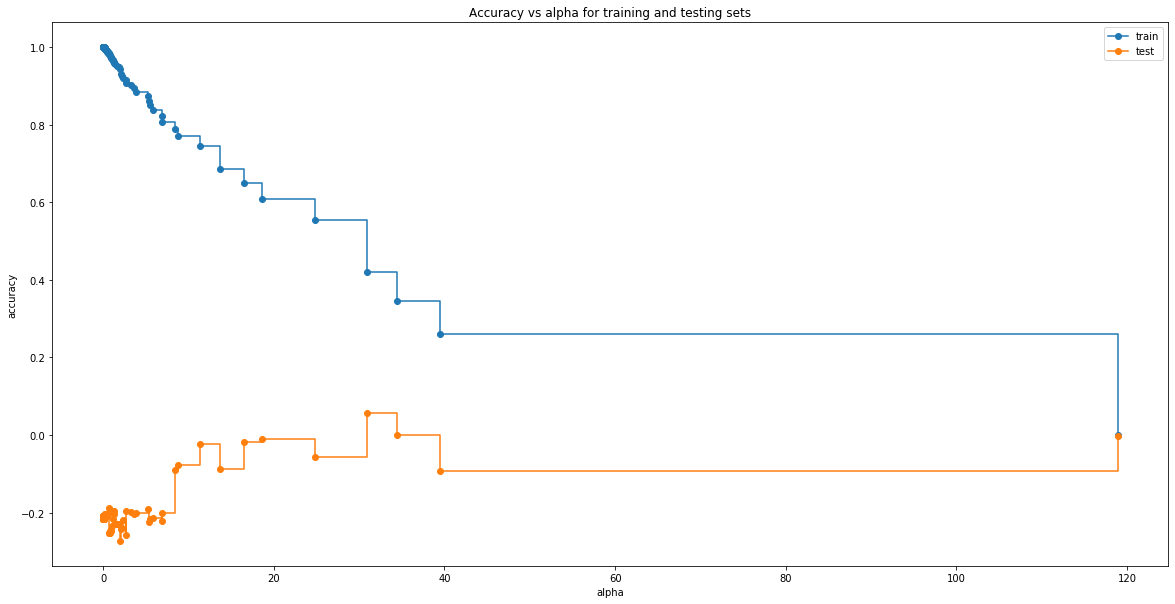

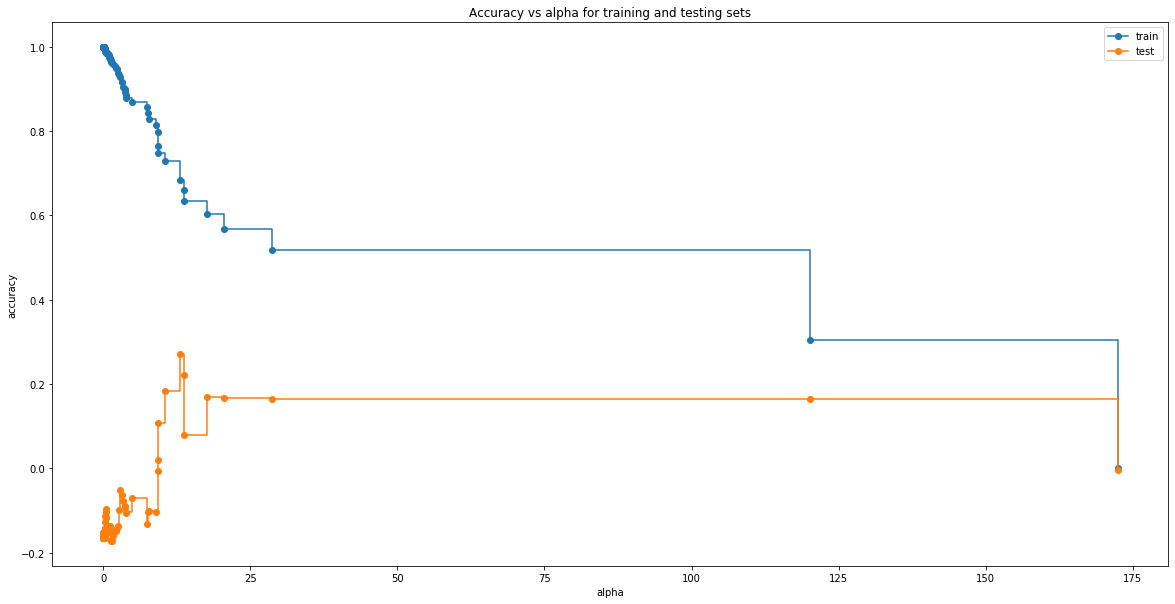

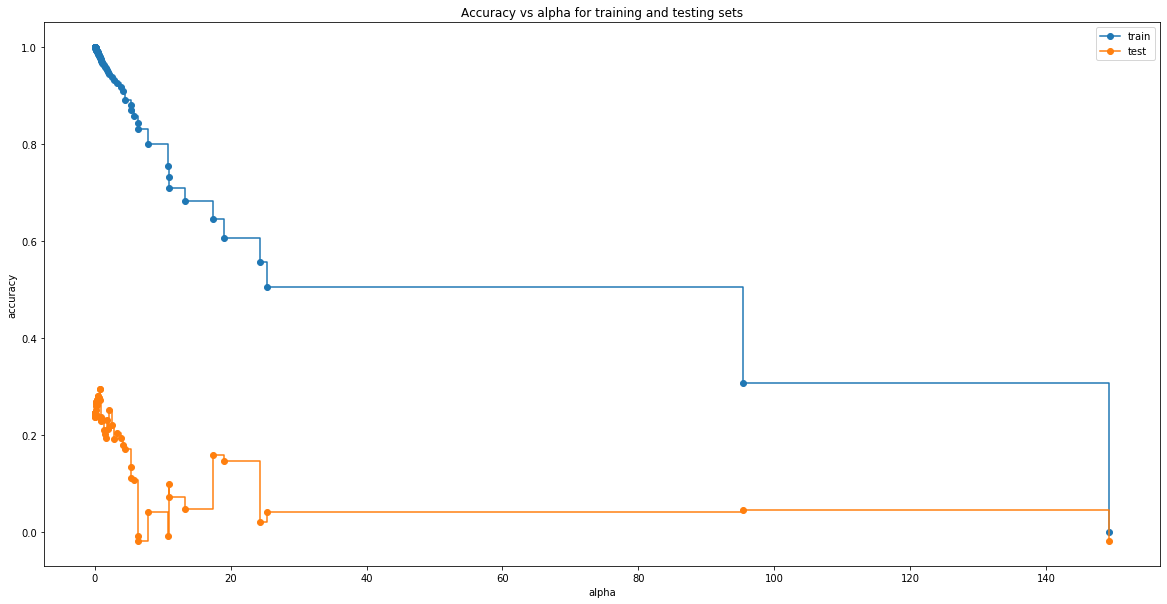

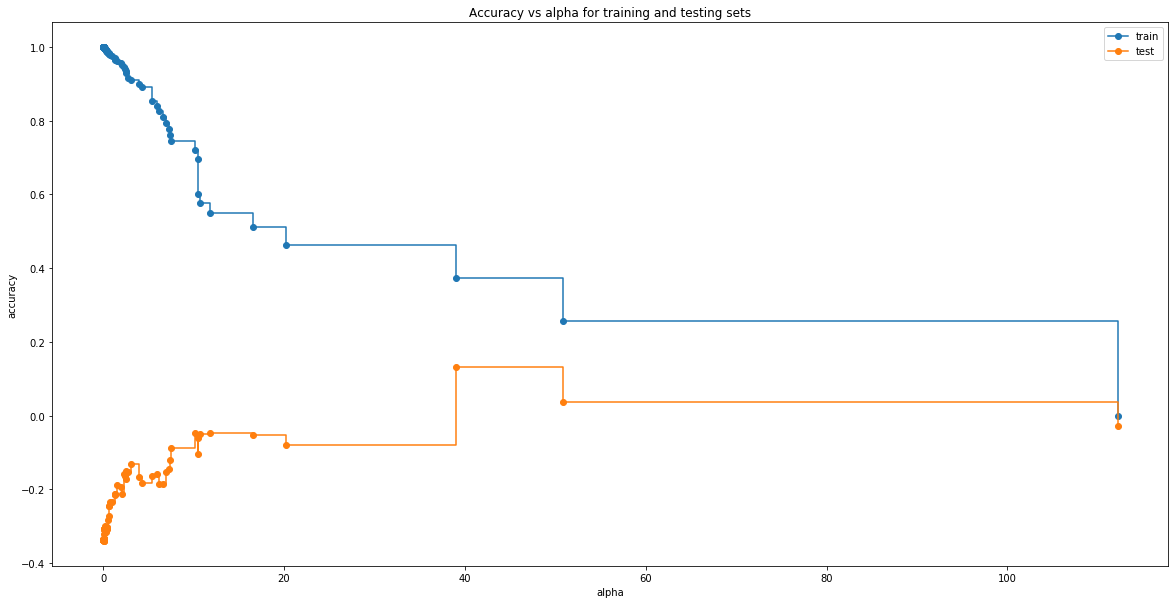

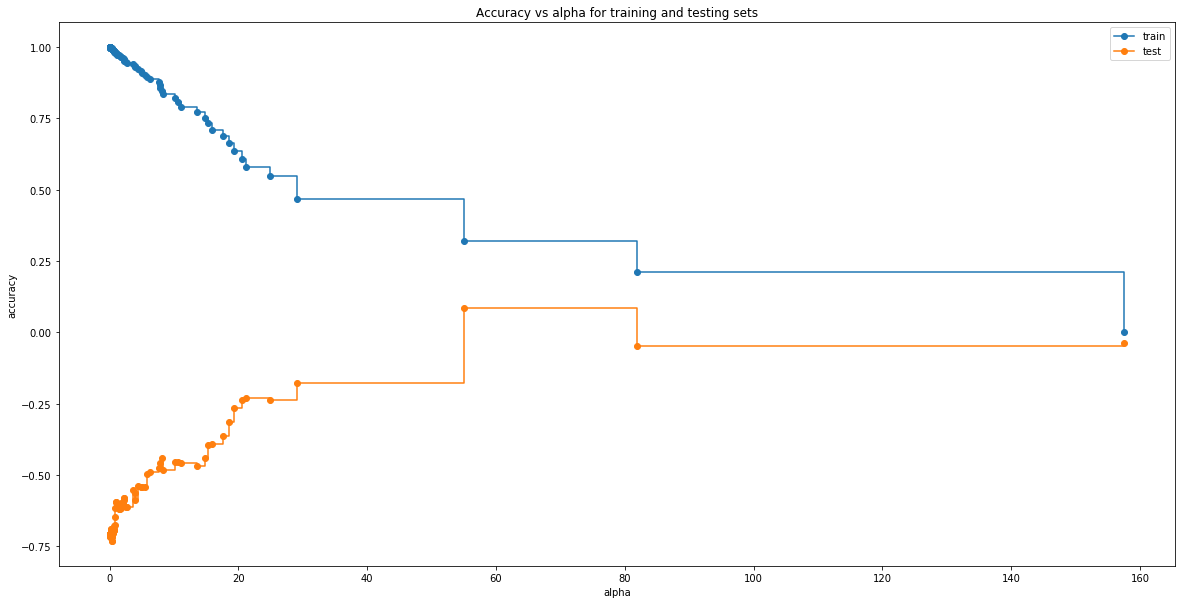

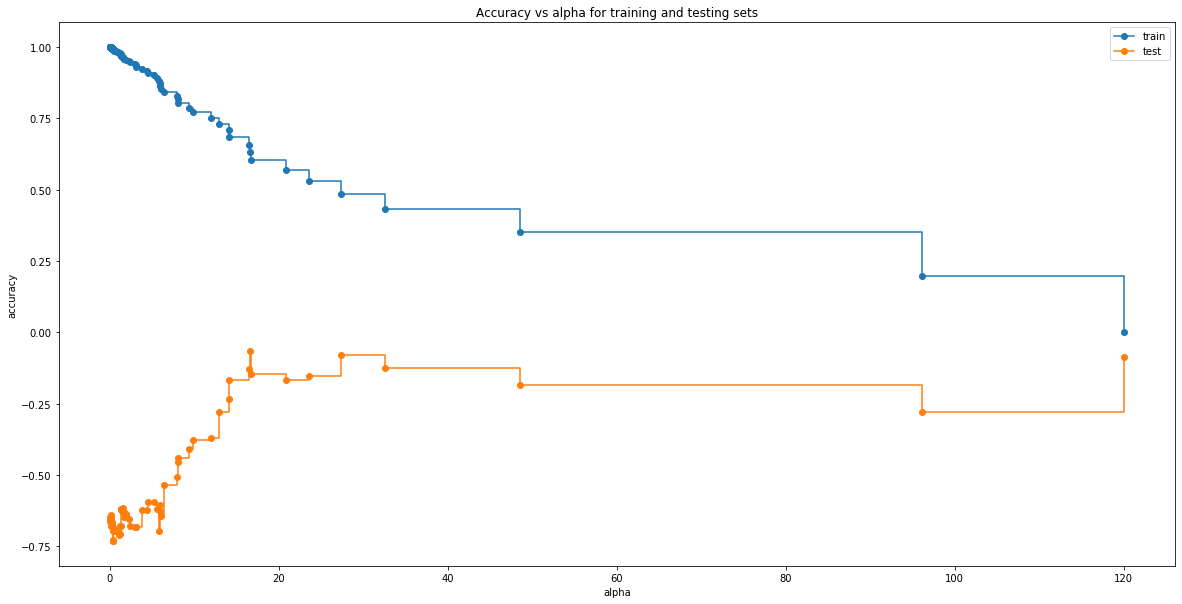

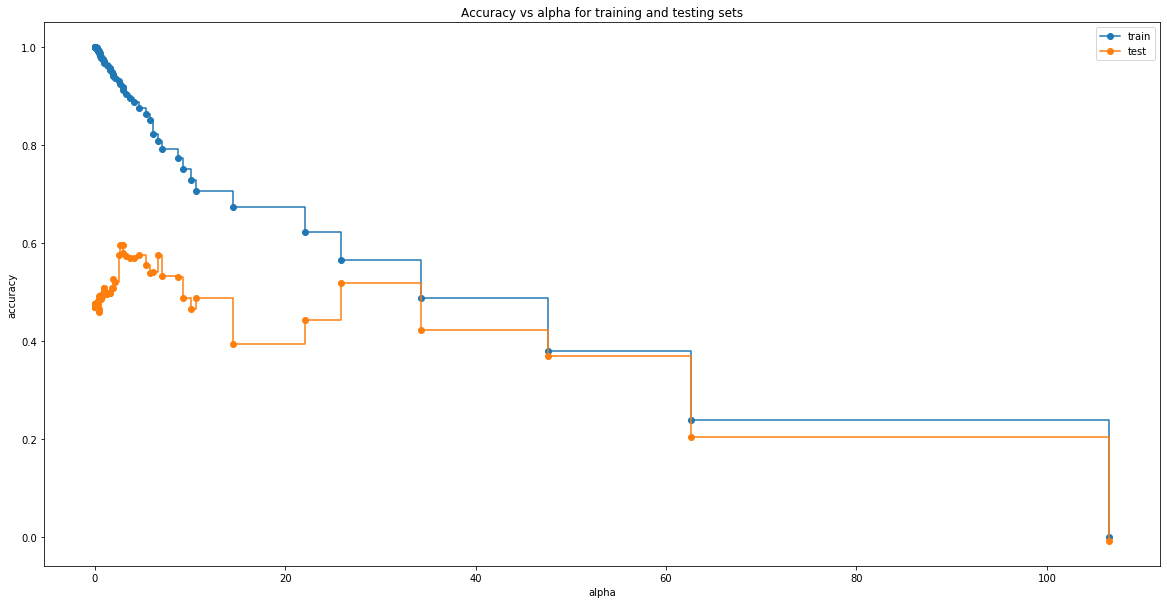

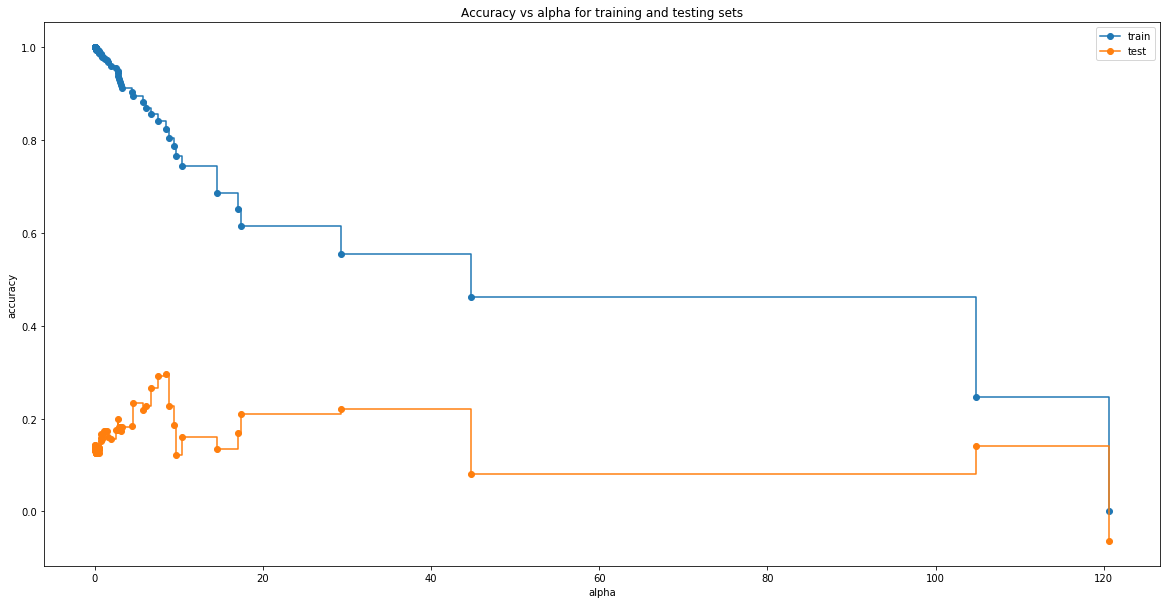

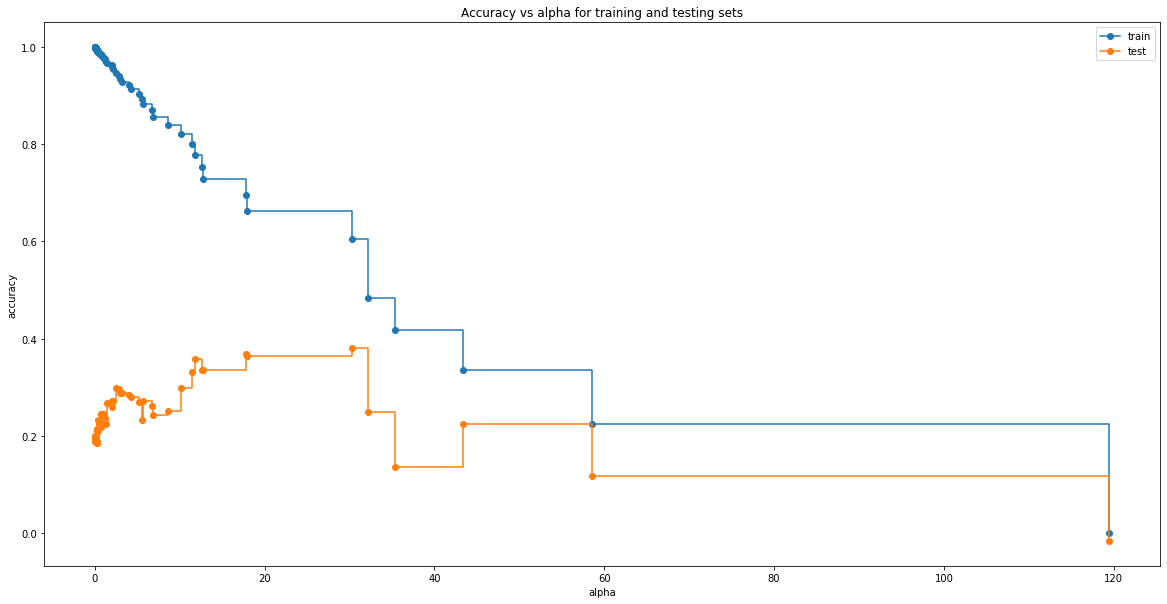

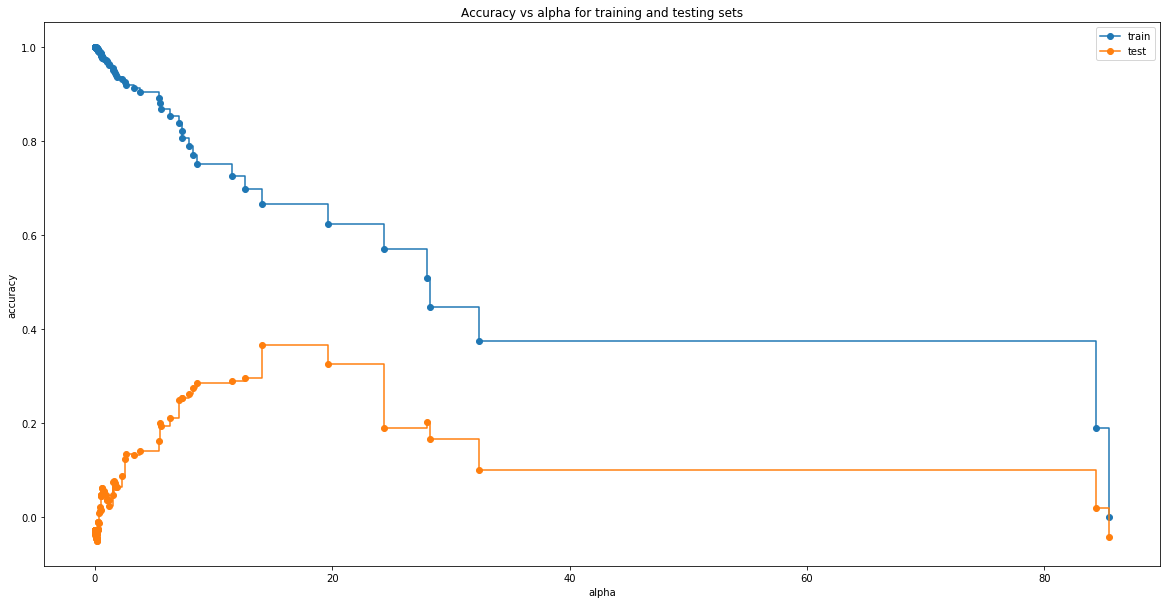

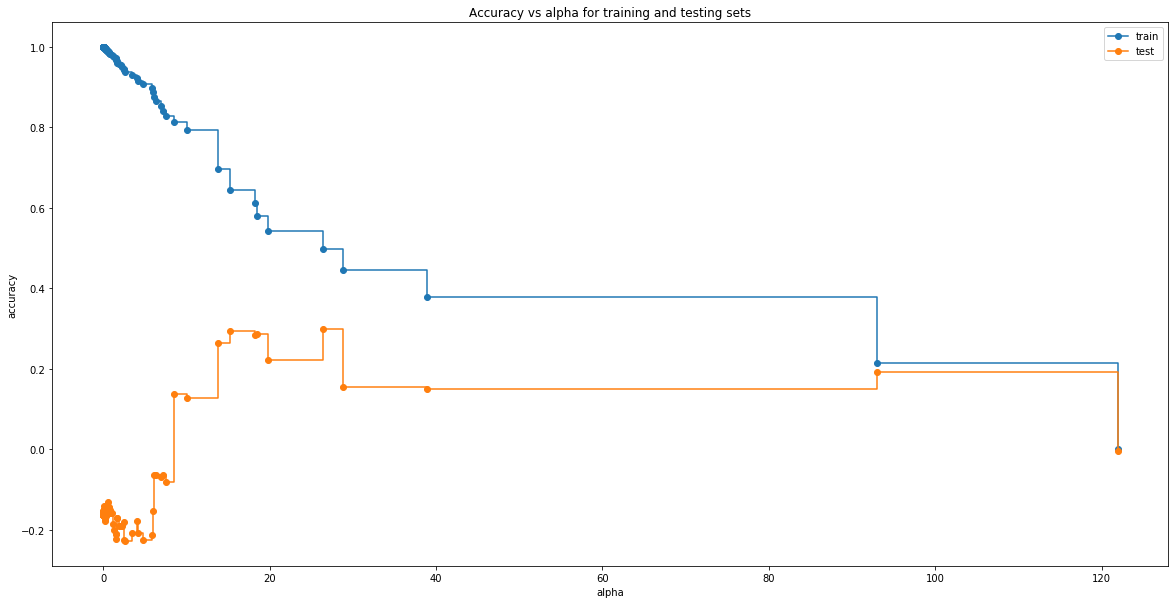

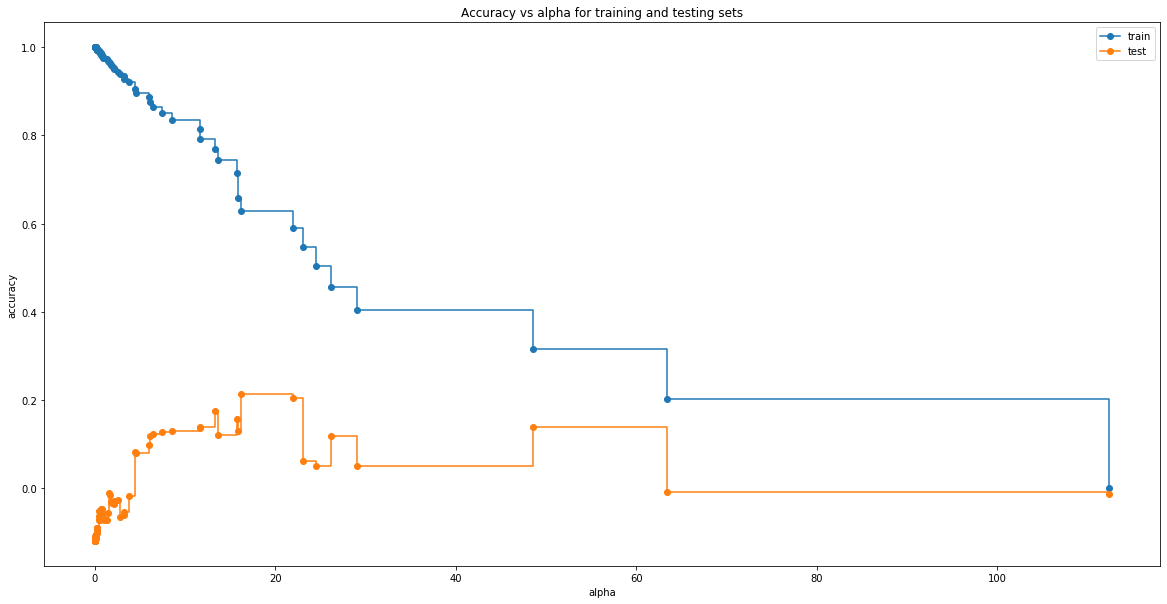

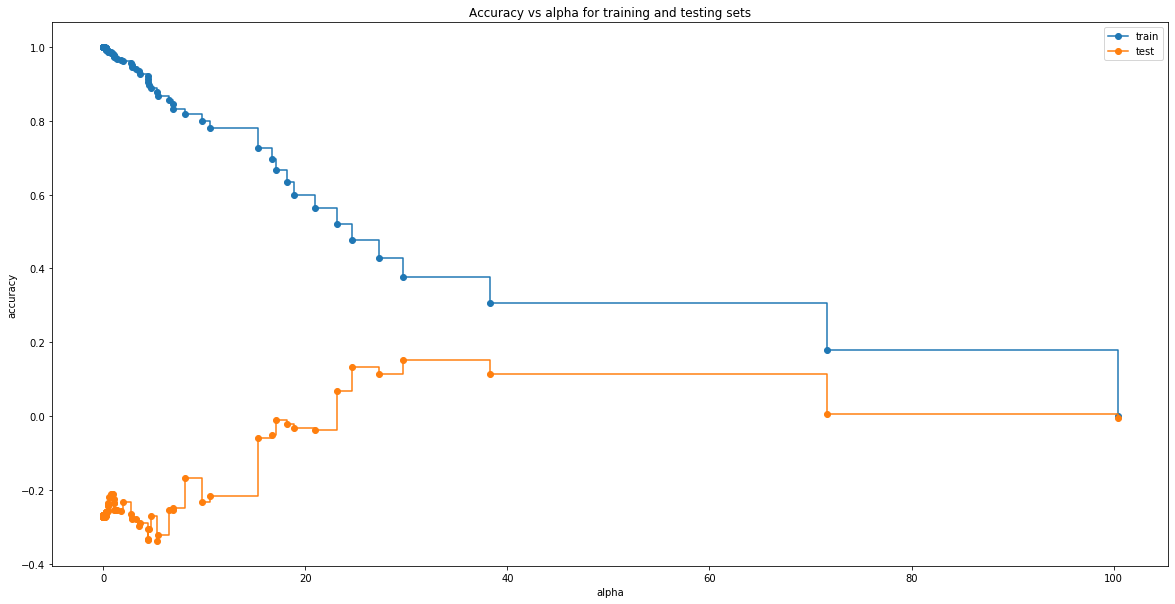

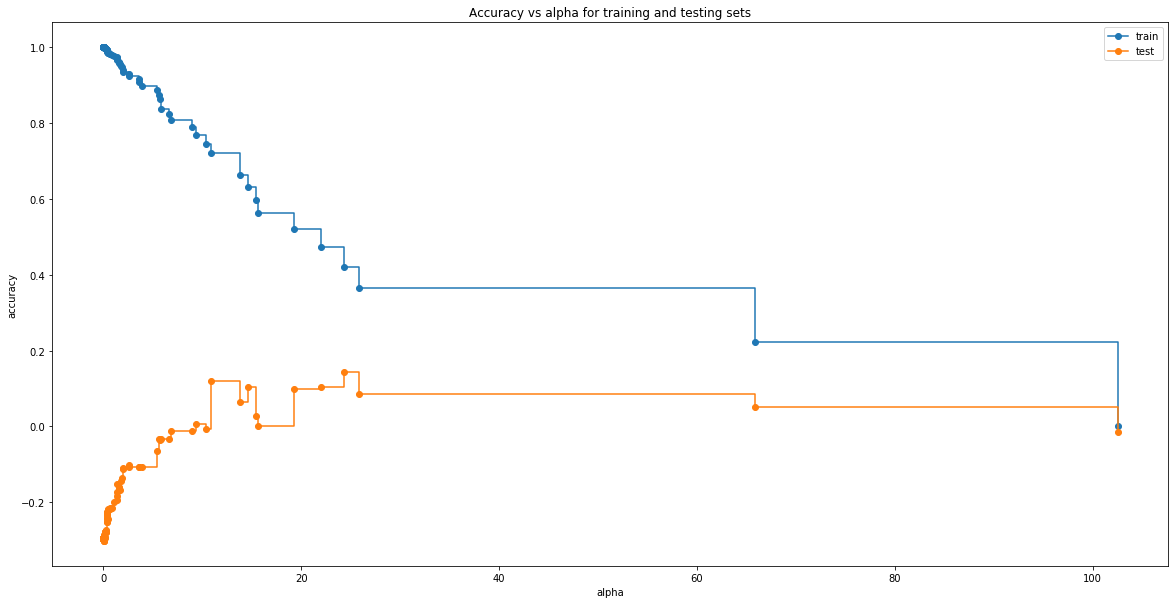

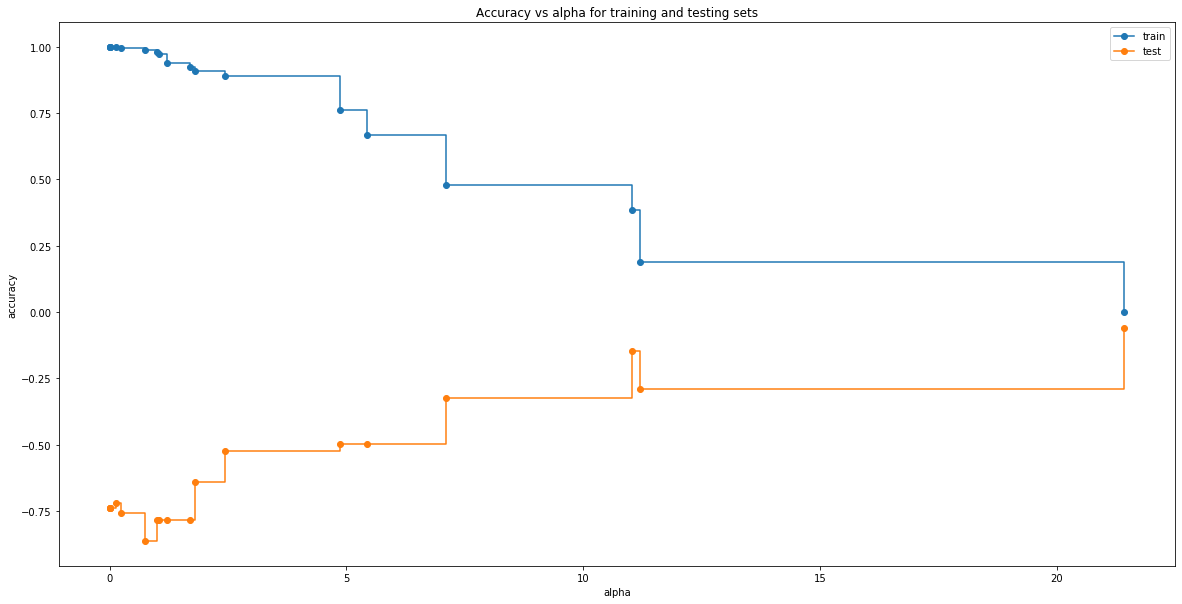

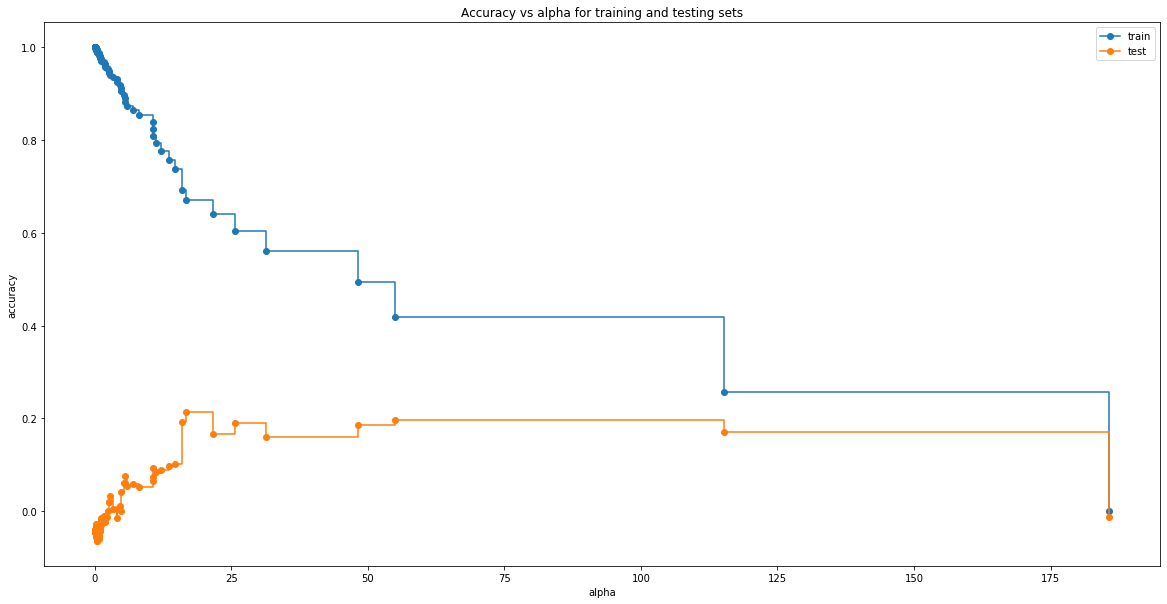

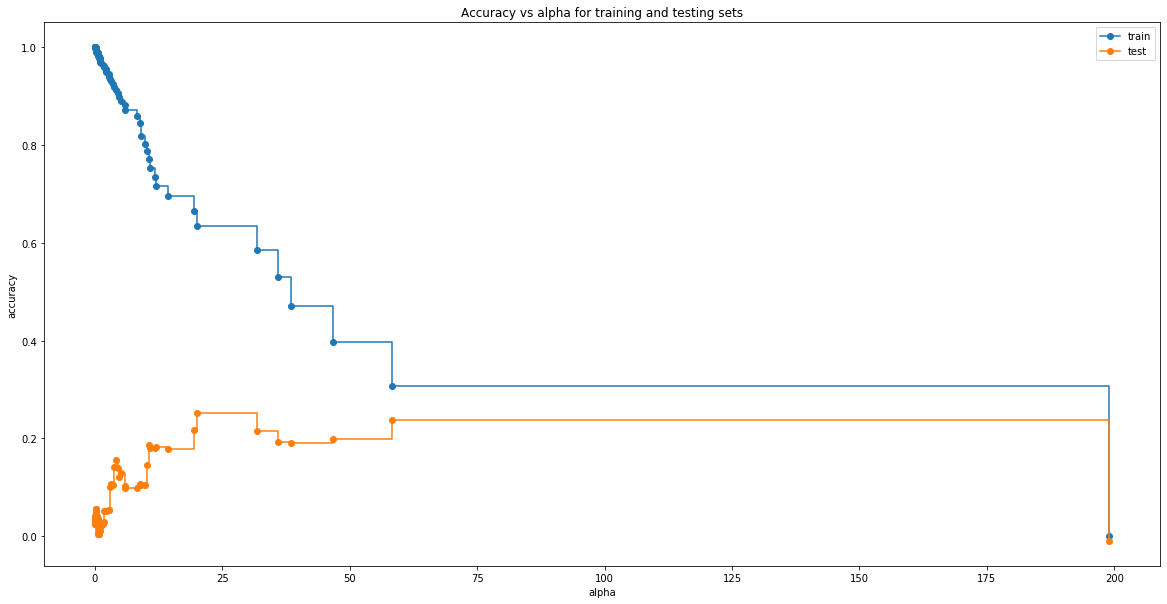

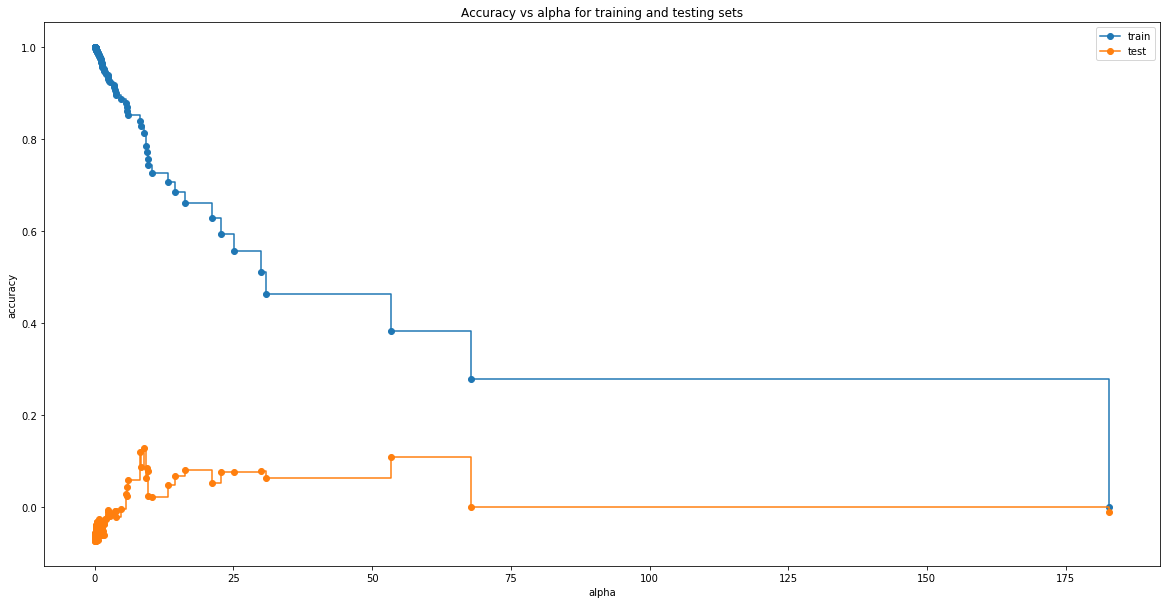

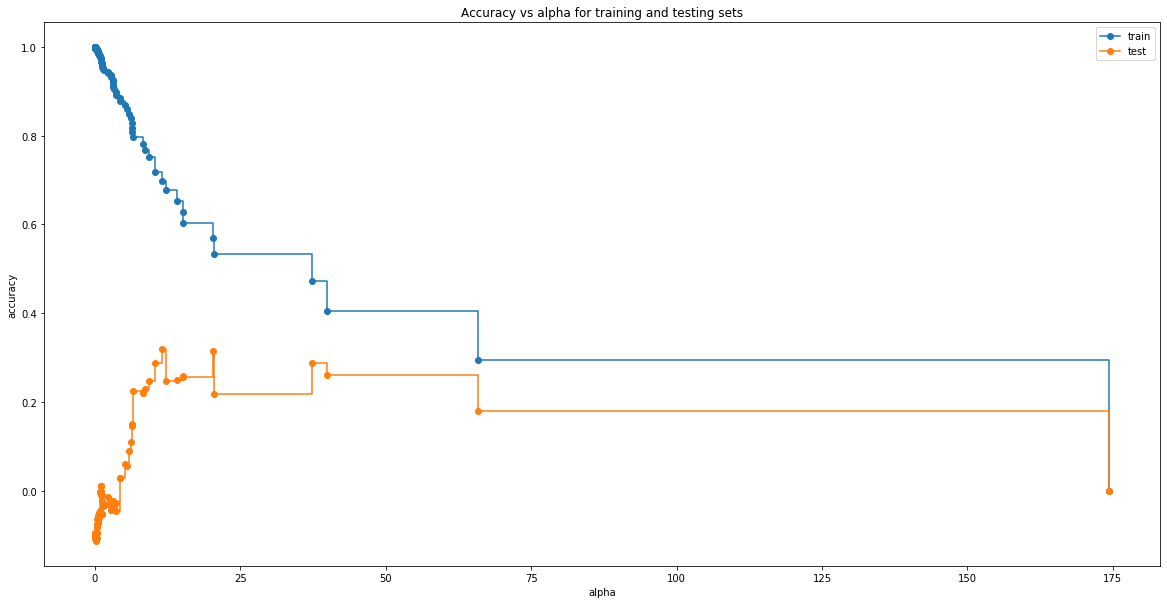

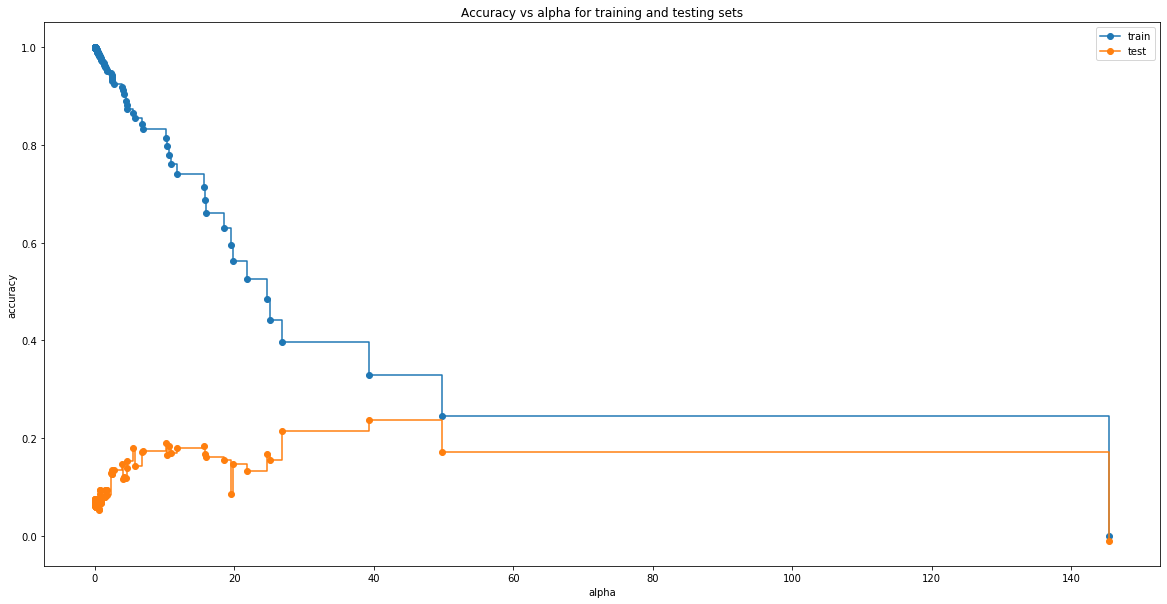

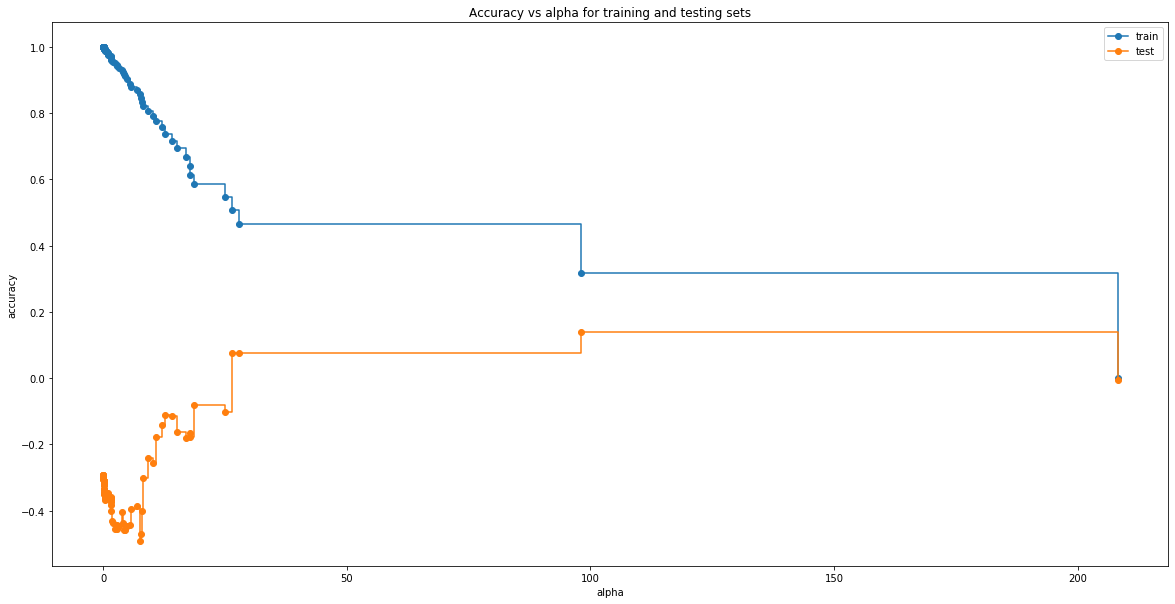

In [464]:
y_list_list = y1w_list + y2w_list + y3w_list


results = []
i=0
for y_list in y_list_list:
    
    X_drop = list(zip(y1_list,x1_list)) + list(zip(y2_list,x2_list)) + list(zip(y3_list,x3_list))
    
    print("../data/output/dtree_%s.png" % (y_list))
    
    ccp_alpha, clf, score,  y_na, X_drop  = dtree_pipe (
                   mod_df = modw_df, 
                   y_list = y_list, # list of response variables, if len()>1, these will be summed or meaned
                   X_list = catg_dummy_list + cont_dummy_list + dummy0_dummy_list, 
                   y_funct = None, # either None, 'sum' or 'mean'. Must be one of non-None if len(y_list)>1
                   X_drop = X_drop[i], # list of additional predictors to drop 
                   vis_filename = "../data/output/dtree_%s.png" % (y_list),
                   ccpa_filename = "../data/output/ccpa_%s.png" % (y_list))
    results.append([y_list, ccp_alpha, clf, score, y_na, X_drop])
    i = i+1

ind_y_results = pd.DataFrame(results, columns = ['var', 'ccp_alpha', 'clf', 
                                                 'score', 'y_na', 'X_drop'])
ind_y_results.to_csv('../data/output/ind_y_results_w.csv',index=False)



In [465]:
temp = ind_y_results.sort_values('score', ascending=False)[ind_y_results.score>.6][[
    'var','score','y_na']]
print(tabulate(temp, tablefmt="pipe", headers="keys", showindex=False))
ind_y_results.sort_values('score', ascending=False)

| var   | score   | y_na   |
|-------|---------|--------|


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,var,ccp_alpha,clf,score,y_na,X_drop
7,OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates_w,2.910219,"DecisionTreeRegressor(ccp_alpha=2.9102193782000594, random_state=0)",0.595633,0.342105,"OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates, OJavaSESubscription_Elem_Imp_Org_JavaWebStartUpdates"
9,OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools_w,30.233988,"DecisionTreeRegressor(ccp_alpha=30.233987747146713, random_state=0)",0.381088,0.337719,"OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools, OJavaSESubscription_Elem_Imp_Org_AutoUpdateTools"
10,OJavaSESubscription_Elem_Sat_Org_Monitoring_w,14.117562,"DecisionTreeRegressor(ccp_alpha=14.117561856375882, random_state=0)",0.366831,0.346491,"OJavaSESubscription_Elem_Sat_Org_Monitoring, OJavaSESubscription_Elem_Imp_Org_Monitoring"
19,OJavaSESubscription_Attr_Sat_CoNeedsUnd_w,11.517589,"DecisionTreeRegressor(ccp_alpha=11.5175888439047, random_state=0)",0.318232,0.100877,"OJavaSESubscription_Attr_Sat_CoNeedsUnd, OJavaSESubscription_Attr_Imp_CoNeedsUnd"
0,Sat_Org_JavaSEAMC_w,41.078082,"DecisionTreeRegressor(ccp_alpha=41.07808187302493, random_state=0)",0.312589,0.197368,"Sat_Org_JavaSEAMC, Use_Org_JavaSEAMC"
11,OJavaSESubscription_Elem_Sat_Org_MyOSupport_w,26.380076,"DecisionTreeRegressor(ccp_alpha=26.380075831189345, random_state=0)",0.298998,0.346491,"OJavaSESubscription_Elem_Sat_Org_MyOSupport, OJavaSESubscription_Elem_Imp_Org_MyOSupport"
8,OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates_w,8.449143,"DecisionTreeRegressor(ccp_alpha=8.449143444132538, random_state=0)",0.296118,0.337719,"OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates, OJavaSESubscription_Elem_Imp_Org_DesktopManageUpdates"
3,Sat_Org_JavaSEMSICustTools_w,0.721805,"DecisionTreeRegressor(ccp_alpha=0.7218045112781972, random_state=0)",0.294655,0.298246,"Sat_Org_JavaSEMSICustTools, Use_Org_JavaSEMSICustTools"
2,Sat_Org_JavaSEDepRuleSet_w,12.998785,"DecisionTreeRegressor(ccp_alpha=12.998785019649532, random_state=0)",0.270339,0.263158,"Sat_Org_JavaSEDepRuleSet, Use_Org_JavaSEDepRuleSet"
17,OJavaSESubscription_Attr_Sat_PhoneSupport_w,20.033783,"DecisionTreeRegressor(ccp_alpha=20.03378343365501, random_state=0)",0.252268,0.192982,"OJavaSESubscription_Attr_Sat_PhoneSupport, OJavaSESubscription_Attr_Imp_PhoneSupport"


../data/output/dtree_y123w_sum.png
['Sat_Org_JavaSEAMC', 'Sat_Org_JavaSEAMC_UsageLog', 'Sat_Org_JavaSEDepRuleSet', 'Sat_Org_JavaSEMSICustTools', 'Sat_Org_JavaSEFlightRec', 'OJavaSESubscription_Elem_Sat_Org_ContinuedInvest', 'OJavaSESubscription_Elem_Sat_Org_PatchesOlderV', 'OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates', 'OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates', 'OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools', 'OJavaSESubscription_Elem_Sat_Org_Monitoring', 'OJavaSESubscription_Elem_Sat_Org_MyOSupport', 'OJavaSESubscription_Elem_Sat_Org_AccessCloud', 'OJavaSESubscription_Elem_Sat_Org_FlexLicensing', 'OJavaSESubscription_Elem_Sat_Org_LegacyJava', 'OJavaSESubscription_Elem_Sat_Org_Other', 'OJavaSESubscription_Attr_Sat_CommMethods', 'OJavaSESubscription_Attr_Sat_PhoneSupport', 'OJavaSESubscription_Attr_Sat_SSKnowledge', 'OJavaSESubscription_Attr_Sat_CoNeedsUnd', 'OJavaSESubscription_Attr_Sat_TrainingQual', 'OJavaSESubscription_Attr_Sat_RepsonseTime', 'Use_Org_JavaS

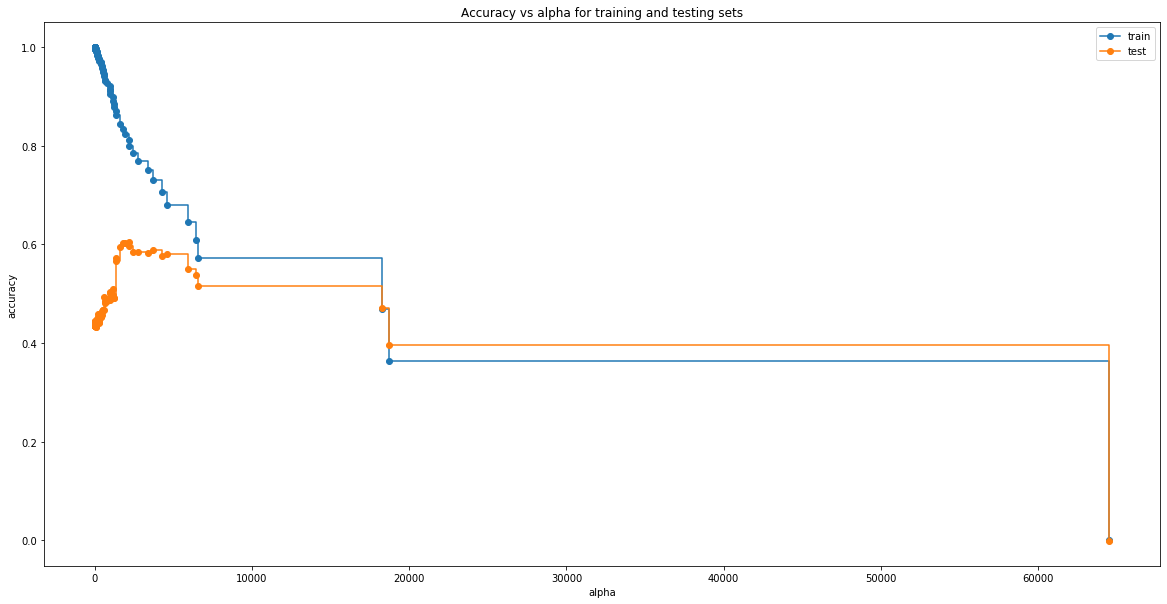

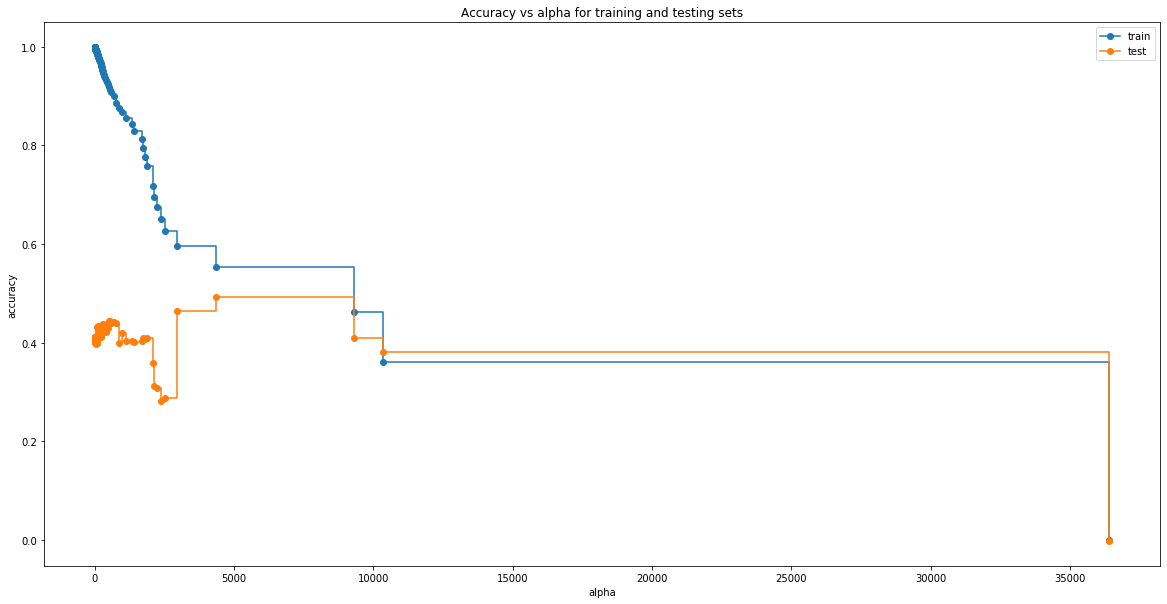

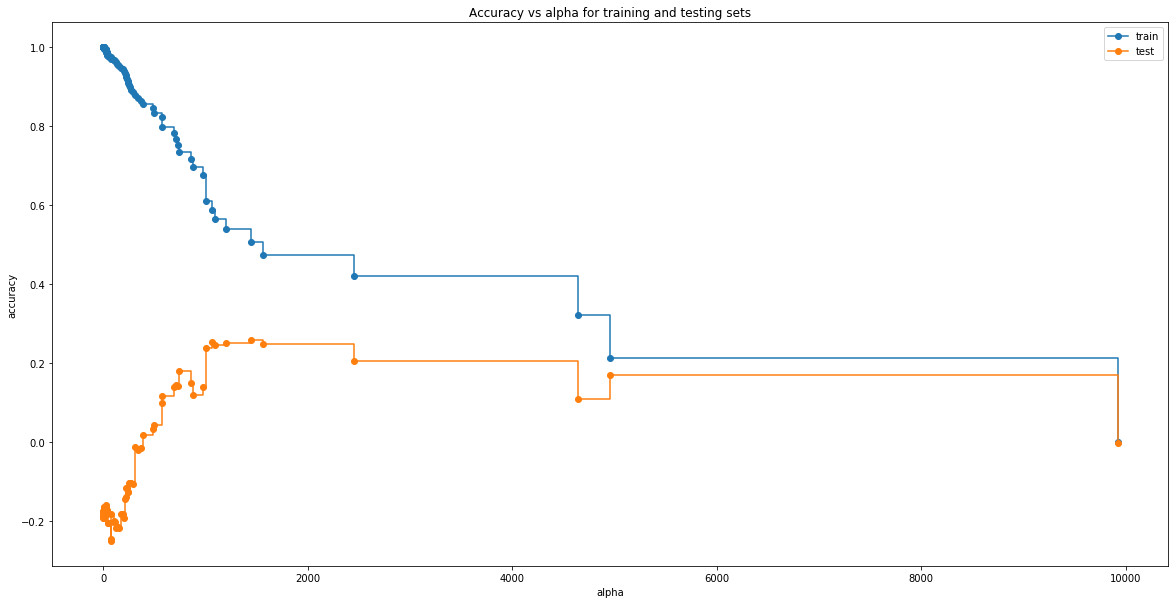

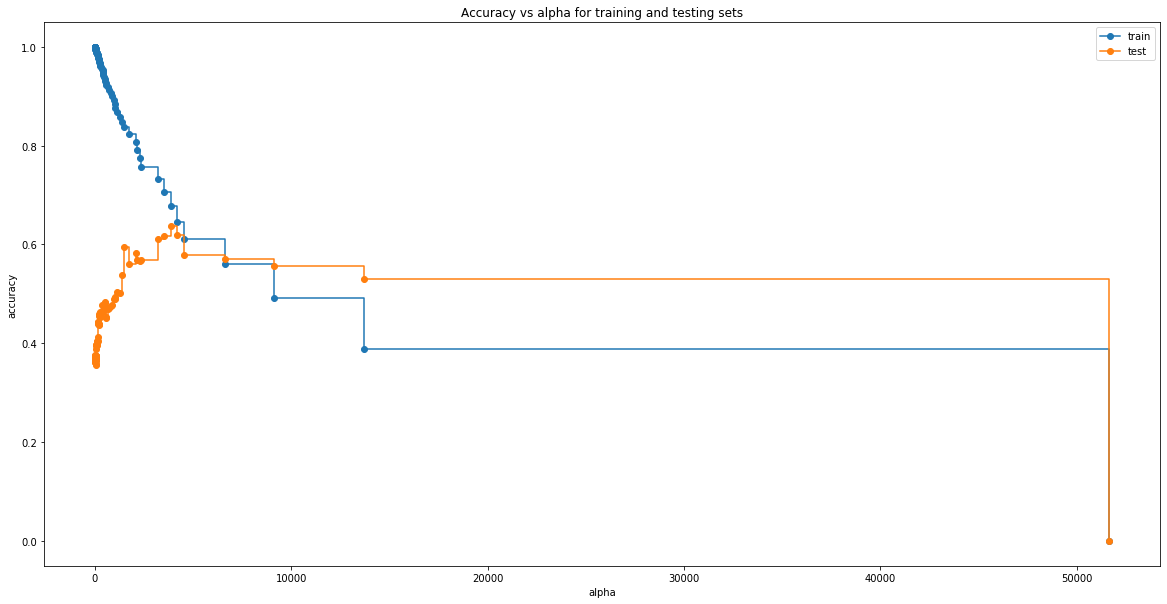

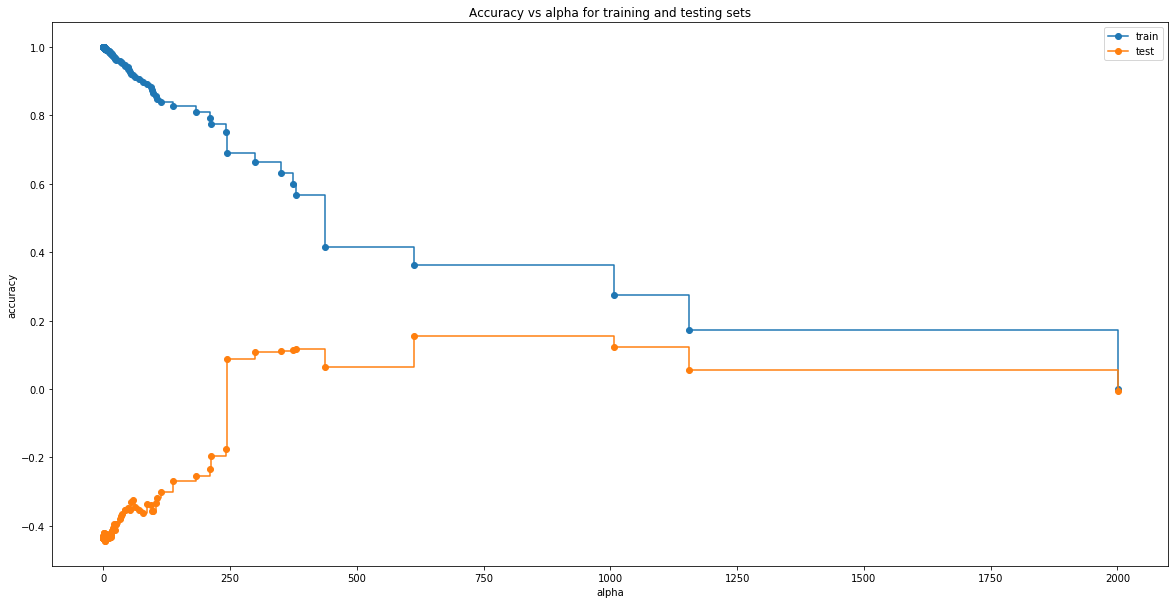

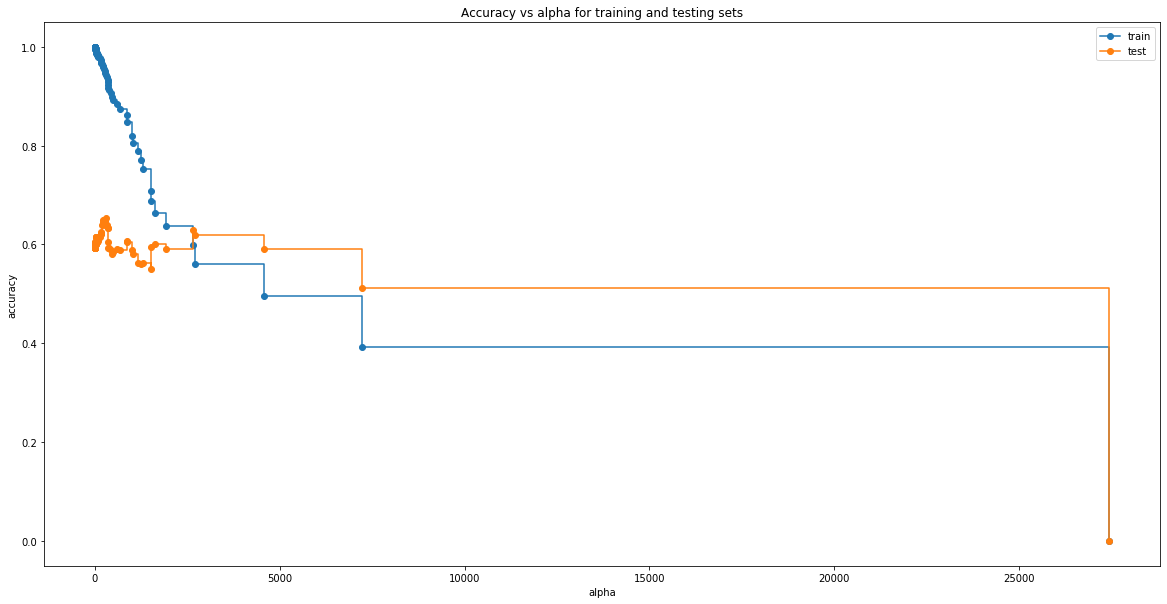

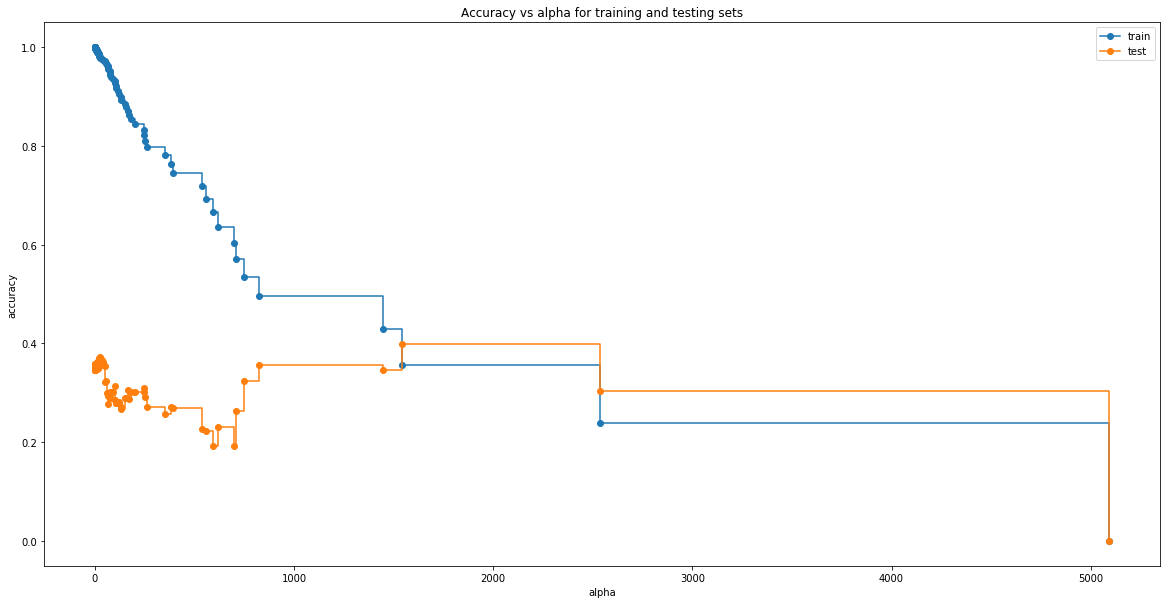

In [468]:
y_list_list = [[y1w_list + y2w_list + y3w_list], 
              [y1w_list + y2w_list], 
              [y1w_list + y3w_list], 
              [y2w_list + y3w_list],
               y1w_list, 
               y2w_list,
               y3w_list]

y_list_names = ['y123w', 'y12w','y13w','y23w','y1w','y2w','y3w']


results = []
i=0
for y_list in y_list_list:
    
    X_drop = [[y1_list + y2_list + y3_list + x1_list + x2_list + x3_list ], 
              [y1_list + y2_list + x1_list + x2_list], 
              [y1_list + y3_list + x1_list + x3_list], 
              [y2_list + y3_list + x2_list + x3_list],
               y1_list + x1_list,  
               y2_list + x2_list,
               y3_list + x3_list]
    
    
    y_funct = 'sum'
    vis_filename = "../data/output/dtree_%s_%s.png" % (y_list_names[i],y_funct)
    ccpa_filename = "../data/output/ccpa_%s_%s.png" % (y_list_names[i],y_funct)
    print(vis_filename)
    
    ccp_alpha, clf, score, y_na, X_drop  = dtree_pipe (
                   mod_df = modw_df, 
                   y_list = y_list, # list of response variables, if len()>1, these will be summed or meaned
                   X_list = catg_dummy_list + cont_dummy_list + dummy0_dummy_list, 
                   y_funct = y_funct, # either None, 'sum' or 'mean'. Must be one of non-None if len(y_list)>1
                   X_drop = X_drop[i], # list of additional predictors to drop 
                   vis_filename =vis_filename,
                   ccpa_filename = ccpa_filename)
    
    print()
    results.append([y_list_names[i], ccp_alpha, clf, score, y_na, X_drop])
    i = i+1

grp_y_sum_results = pd.DataFrame(results, columns = ['var', 'ccp_alpha', 'clf', 
                                                      'score', 'y_na', "X_drop"])
grp_y_sum_results.to_csv('../data/output/grp_y_sum_results_w.csv',index=False)

In [469]:
temp = grp_y_sum_results.sort_values('score', ascending=False)[grp_y_sum_results.score>.6][[
    'var','score','y_na']]
print(tabulate(temp, tablefmt="pipe", headers="keys", showindex=False))
grp_y_sum_results.sort_values('score', ascending=False)

| var   |    score |   y_na |
|:------|---------:|-------:|
| y2w   | 0.654119 |      0 |
| y23w  | 0.636916 |      0 |
| y123w | 0.603959 |      0 |


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,var,ccp_alpha,clf,score,y_na,X_drop
5,y2w,306.672515,"DecisionTreeRegressor(ccp_alpha=306.67251461988303, random_state=0)",0.654119,0.0,"OJavaSESubscription_Elem_Sat_Org_ContinuedInvest, OJavaSESubscription_Elem_Sat_Org_PatchesOlderV, OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates, OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates, OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools, OJavaSESubscription_Elem_Sat_Org_Monitoring, OJavaSESubscription_Elem_Sat_Org_MyOSupport, OJavaSESubscription_Elem_Sat_Org_AccessCloud, OJa..."
3,y23w,3870.883061,"DecisionTreeRegressor(ccp_alpha=3870.883061241093, random_state=0)",0.636916,0.0,"OJavaSESubscription_Elem_Sat_Org_ContinuedInvest, OJavaSESubscription_Elem_Sat_Org_PatchesOlderV, OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates, OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates, OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools, OJavaSESubscription_Elem_Sat_Org_Monitoring, OJavaSESubscription_Elem_Sat_Org_MyOSupport, OJavaSESubscription_Elem_Sat_Org_AccessCloud, OJa..."
0,y123w,2165.155768,"DecisionTreeRegressor(ccp_alpha=2165.1557682084003, random_state=0)",0.603959,0.0,"Sat_Org_JavaSEAMC, Sat_Org_JavaSEAMC_UsageLog, Sat_Org_JavaSEDepRuleSet, Sat_Org_JavaSEMSICustTools, Sat_Org_JavaSEFlightRec, OJavaSESubscription_Elem_Sat_Org_ContinuedInvest, OJavaSESubscription_Elem_Sat_Org_PatchesOlderV, OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates, OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates, OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools, OJavaSESubscr..."
1,y12w,4339.189147,"DecisionTreeRegressor(ccp_alpha=4339.189146701871, random_state=0)",0.493376,0.0,"Sat_Org_JavaSEAMC, Sat_Org_JavaSEAMC_UsageLog, Sat_Org_JavaSEDepRuleSet, Sat_Org_JavaSEMSICustTools, Sat_Org_JavaSEFlightRec, OJavaSESubscription_Elem_Sat_Org_ContinuedInvest, OJavaSESubscription_Elem_Sat_Org_PatchesOlderV, OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates, OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates, OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools, OJavaSESubscr..."
6,y3w,1541.823650,"DecisionTreeRegressor(ccp_alpha=1541.82365003418, random_state=0)",0.399303,0.0,"OJavaSESubscription_Attr_Sat_CommMethods, OJavaSESubscription_Attr_Sat_PhoneSupport, OJavaSESubscription_Attr_Sat_SSKnowledge, OJavaSESubscription_Attr_Sat_CoNeedsUnd, OJavaSESubscription_Attr_Sat_TrainingQual, OJavaSESubscription_Attr_Sat_RepsonseTime, OJavaSESubscription_Attr_Imp_CommMethods, OJavaSESubscription_Attr_Imp_PhoneSupport, OJavaSESubscription_Attr_Imp_SSKnowledge, OJavaSESubscrip..."
2,y13w,1443.187201,"DecisionTreeRegressor(ccp_alpha=1443.187201195109, random_state=0)",0.258936,0.0,"Sat_Org_JavaSEAMC, Sat_Org_JavaSEAMC_UsageLog, Sat_Org_JavaSEDepRuleSet, Sat_Org_JavaSEMSICustTools, Sat_Org_JavaSEFlightRec, OJavaSESubscription_Attr_Sat_CommMethods, OJavaSESubscription_Attr_Sat_PhoneSupport, OJavaSESubscription_Attr_Sat_SSKnowledge, OJavaSESubscription_Attr_Sat_CoNeedsUnd, OJavaSESubscription_Attr_Sat_TrainingQual, OJavaSESubscription_Attr_Sat_RepsonseTime, Use_Org_JavaSEAM..."
4,y1w,613.613915,"DecisionTreeRegressor(ccp_alpha=613.613914587484, random_state=0)",0.153603,0.0,"Sat_Org_JavaSEAMC, Sat_Org_JavaSEAMC_UsageLog, Sat_Org_JavaSEDepRuleSet, Sat_Org_JavaSEMSICustTools, Sat_Org_JavaSEFlightRec, Use_Org_JavaSEAMC, Use_Org_JavaSEAMC_UsageLog, Use_Org_JavaSEDepRuleSet, Use_Org_JavaSEMSICustTools, Use_Org_JavaSEFlightRec"


../data/output/dtree_y123w_mean.png
['Sat_Org_JavaSEAMC', 'Sat_Org_JavaSEAMC_UsageLog', 'Sat_Org_JavaSEDepRuleSet', 'Sat_Org_JavaSEMSICustTools', 'Sat_Org_JavaSEFlightRec', 'OJavaSESubscription_Elem_Sat_Org_ContinuedInvest', 'OJavaSESubscription_Elem_Sat_Org_PatchesOlderV', 'OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates', 'OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates', 'OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools', 'OJavaSESubscription_Elem_Sat_Org_Monitoring', 'OJavaSESubscription_Elem_Sat_Org_MyOSupport', 'OJavaSESubscription_Elem_Sat_Org_AccessCloud', 'OJavaSESubscription_Elem_Sat_Org_FlexLicensing', 'OJavaSESubscription_Elem_Sat_Org_LegacyJava', 'OJavaSESubscription_Elem_Sat_Org_Other', 'OJavaSESubscription_Attr_Sat_CommMethods', 'OJavaSESubscription_Attr_Sat_PhoneSupport', 'OJavaSESubscription_Attr_Sat_SSKnowledge', 'OJavaSESubscription_Attr_Sat_CoNeedsUnd', 'OJavaSESubscription_Attr_Sat_TrainingQual', 'OJavaSESubscription_Attr_Sat_RepsonseTime', 'Use_Org_Java

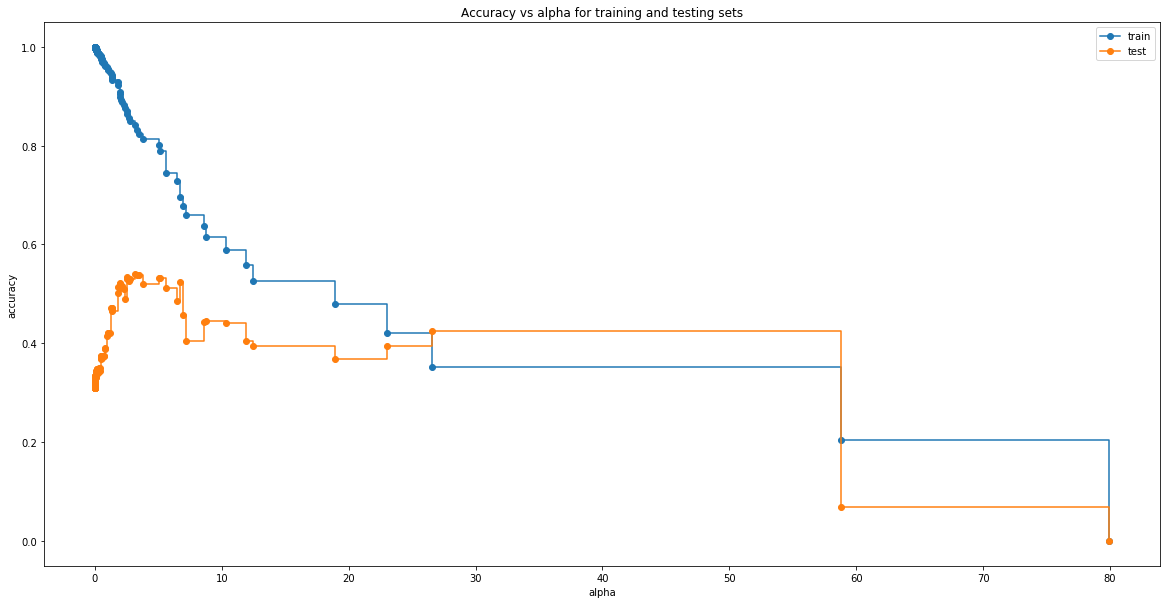

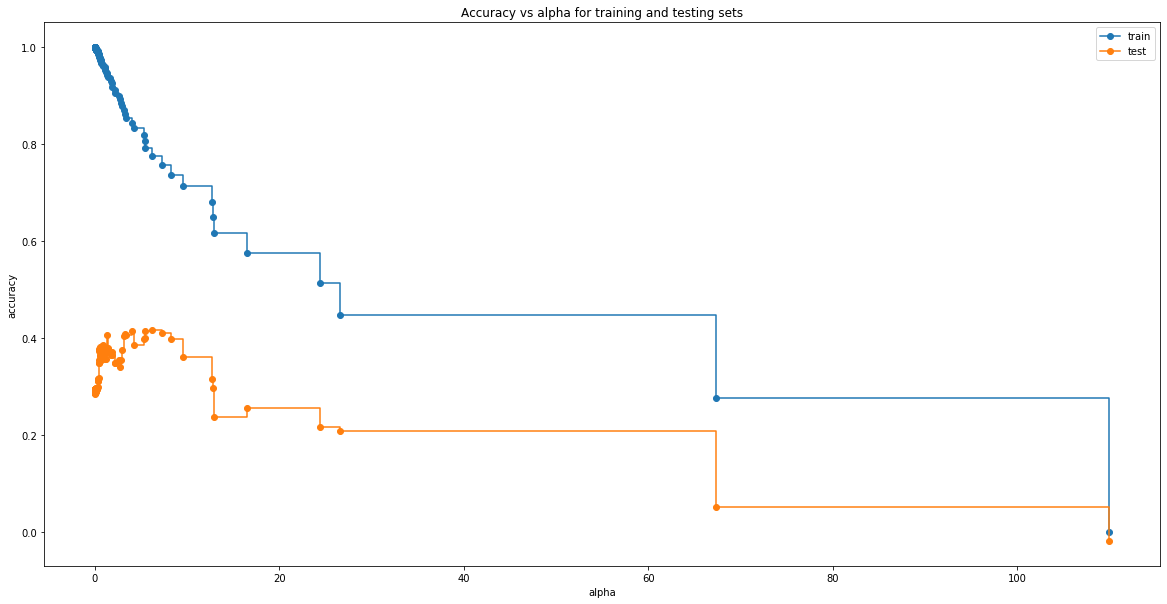

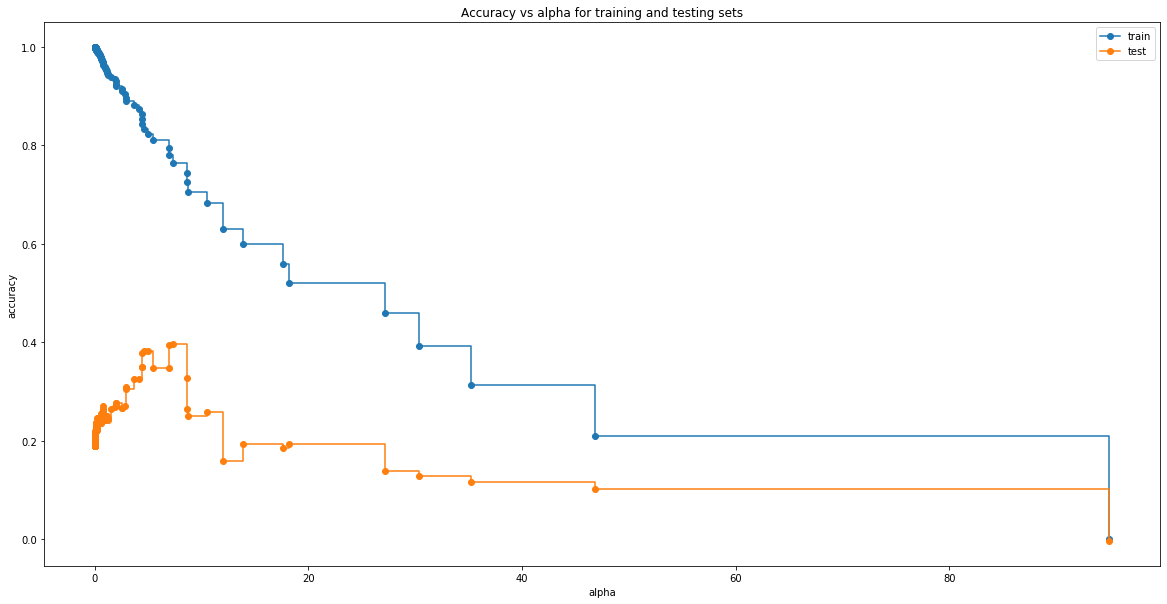

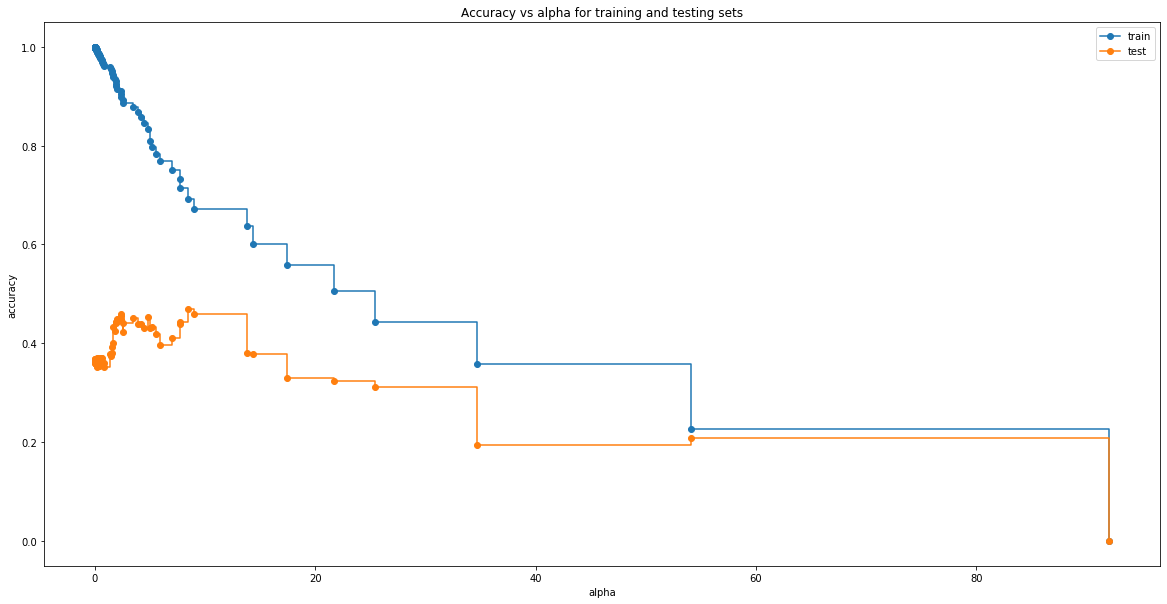

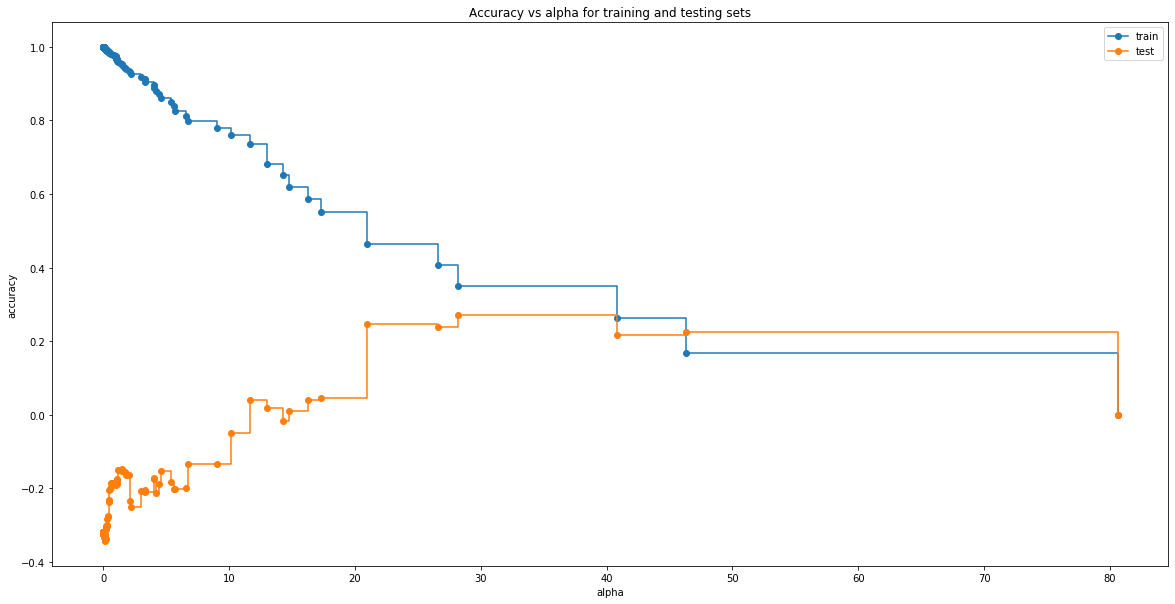

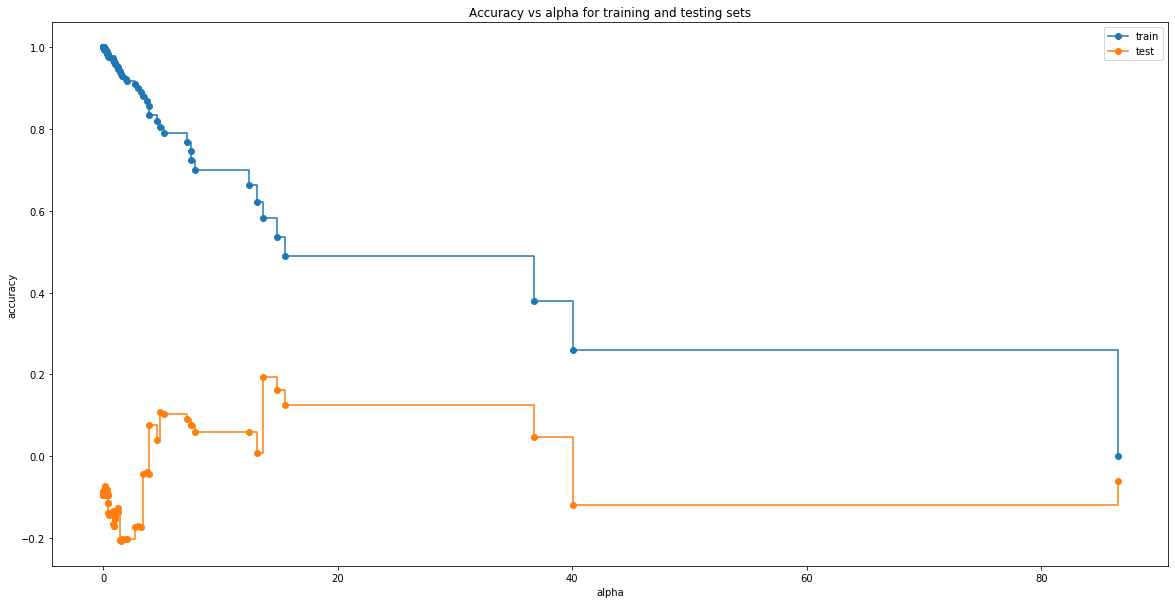

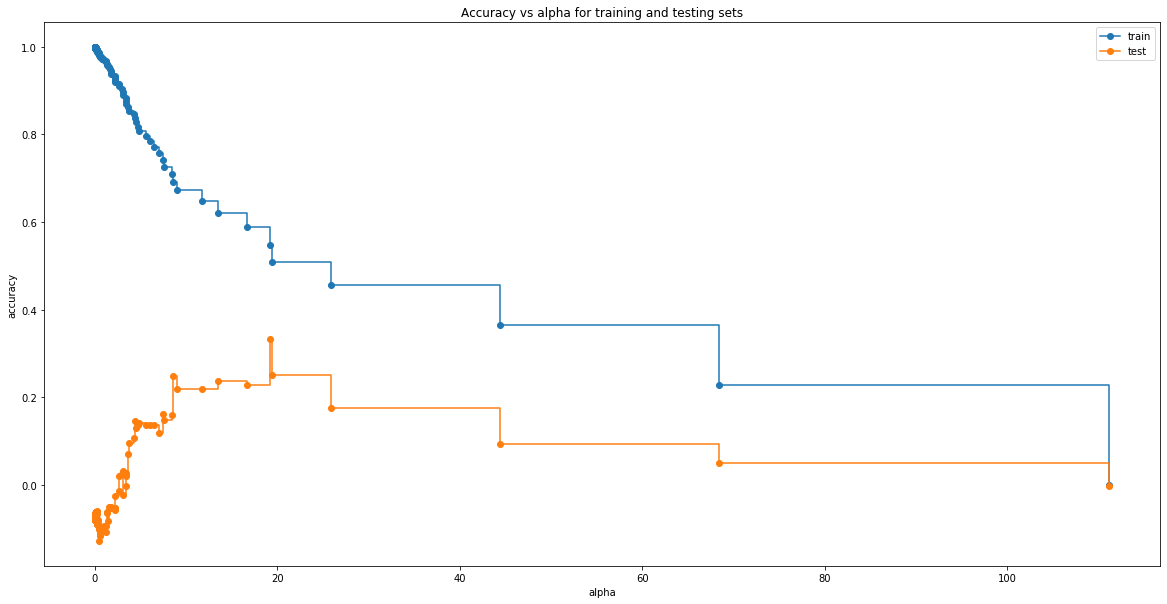

In [470]:
y_list_list = [[y1w_list + y2w_list + y3w_list], 
              [y1w_list + y2w_list], 
              [y1w_list + y3w_list], 
              [y2w_list + y3w_list],
               y1w_list, 
               y2w_list,
               y3w_list]

y_list_names = ['y123w', 'y12w','y13w','y23w','y1w','y2w','y3w']


results = []
i=0
for y_list in y_list_list:
    
    X_drop = [[y1_list + y2_list + y3_list + x1_list + x2_list + x3_list ], 
              [y1_list + y2_list + x1_list + x2_list], 
              [y1_list + y3_list + x1_list + x3_list], 
              [y2_list + y3_list + x2_list + x3_list],
               y1_list + x1_list,  
               y2_list + x2_list,
               y3_list + x3_list]
    
    y_funct = 'mean'
    vis_filename = "../data/output/dtree_%s_%s.png" % (y_list_names[i],y_funct)
    ccpa_filename = "../data/output/ccpa_%s_%s.png" % (y_list_names[i],y_funct)
    print(vis_filename)
    
    ccp_alpha, clf, score, y_na, X_drop  = dtree_pipe (
                   mod_df = modw_df, 
                   y_list = y_list, # list of response variables, if len()>1, these will be summed or meaned
                   X_list = catg_dummy_list + cont_dummy_list + dummy0_dummy_list, 
                   y_funct = y_funct, # either None, 'sum' or 'mean'. Must be one of non-None if len(y_list)>1
                   X_drop = X_drop[i], # list of additional predictors to drop 
                   vis_filename =vis_filename,
                   ccpa_filename = ccpa_filename)
    
    results.append([y_list_names[i], ccp_alpha, clf, score, y_na, X_drop])
    i = i+1

grp_y_mean_results = pd.DataFrame(results, columns = ['var', 'ccp_alpha', 'clf', 
                                                      'score', 'y_na',"X_drop"])
grp_y_mean_results.to_csv('../data/output/grp_y_mean_results_w.csv',index=False)

In [471]:
temp = grp_y_mean_results.sort_values('score', ascending=False)[grp_y_mean_results.score>.6][[
    'var','score','y_na']]
print(tabulate(temp, tablefmt="pipe", headers="keys", showindex=False))
grp_y_mean_results.sort_values('score', ascending=False)

| var   | score   | y_na   |
|-------|---------|--------|


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,var,ccp_alpha,clf,score,y_na,X_drop
0,y123w,3.202872,"DecisionTreeRegressor(ccp_alpha=3.202871504119143, random_state=0)",0.539480,0.030702,"Sat_Org_JavaSEAMC, Sat_Org_JavaSEAMC_UsageLog, Sat_Org_JavaSEDepRuleSet, Sat_Org_JavaSEMSICustTools, Sat_Org_JavaSEFlightRec, OJavaSESubscription_Elem_Sat_Org_ContinuedInvest, OJavaSESubscription_Elem_Sat_Org_PatchesOlderV, OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates, OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates, OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools, OJavaSESubscr..."
3,y23w,8.475750,"DecisionTreeRegressor(ccp_alpha=8.47574984399099, random_state=0)",0.469979,0.039474,"OJavaSESubscription_Elem_Sat_Org_ContinuedInvest, OJavaSESubscription_Elem_Sat_Org_PatchesOlderV, OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates, OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates, OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools, OJavaSESubscription_Elem_Sat_Org_Monitoring, OJavaSESubscription_Elem_Sat_Org_MyOSupport, OJavaSESubscription_Elem_Sat_Org_AccessCloud, OJa..."
1,y12w,6.199281,"DecisionTreeRegressor(ccp_alpha=6.19928132945436, random_state=0)",0.416003,0.061404,"Sat_Org_JavaSEAMC, Sat_Org_JavaSEAMC_UsageLog, Sat_Org_JavaSEDepRuleSet, Sat_Org_JavaSEMSICustTools, Sat_Org_JavaSEFlightRec, OJavaSESubscription_Elem_Sat_Org_ContinuedInvest, OJavaSESubscription_Elem_Sat_Org_PatchesOlderV, OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates, OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates, OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools, OJavaSESubscr..."
2,y13w,7.304527,"DecisionTreeRegressor(ccp_alpha=7.304527308337704, random_state=0)",0.396668,0.030702,"Sat_Org_JavaSEAMC, Sat_Org_JavaSEAMC_UsageLog, Sat_Org_JavaSEDepRuleSet, Sat_Org_JavaSEMSICustTools, Sat_Org_JavaSEFlightRec, OJavaSESubscription_Attr_Sat_CommMethods, OJavaSESubscription_Attr_Sat_PhoneSupport, OJavaSESubscription_Attr_Sat_SSKnowledge, OJavaSESubscription_Attr_Sat_CoNeedsUnd, OJavaSESubscription_Attr_Sat_TrainingQual, OJavaSESubscription_Attr_Sat_RepsonseTime, Use_Org_JavaSEAM..."
6,y3w,19.152809,"DecisionTreeRegressor(ccp_alpha=19.152809272057866, random_state=0)",0.333448,0.048246,"OJavaSESubscription_Attr_Sat_CommMethods, OJavaSESubscription_Attr_Sat_PhoneSupport, OJavaSESubscription_Attr_Sat_SSKnowledge, OJavaSESubscription_Attr_Sat_CoNeedsUnd, OJavaSESubscription_Attr_Sat_TrainingQual, OJavaSESubscription_Attr_Sat_RepsonseTime, OJavaSESubscription_Attr_Imp_CommMethods, OJavaSESubscription_Attr_Imp_PhoneSupport, OJavaSESubscription_Attr_Imp_SSKnowledge, OJavaSESubscrip..."
4,y1w,28.203938,"DecisionTreeRegressor(ccp_alpha=28.203937779383537, random_state=0)",0.270103,0.149123,"Sat_Org_JavaSEAMC, Sat_Org_JavaSEAMC_UsageLog, Sat_Org_JavaSEDepRuleSet, Sat_Org_JavaSEMSICustTools, Sat_Org_JavaSEFlightRec, Use_Org_JavaSEAMC, Use_Org_JavaSEAMC_UsageLog, Use_Org_JavaSEDepRuleSet, Use_Org_JavaSEMSICustTools, Use_Org_JavaSEFlightRec"
5,y2w,13.616558,"DecisionTreeRegressor(ccp_alpha=13.616558141079569, random_state=0)",0.193438,0.219298,"OJavaSESubscription_Elem_Sat_Org_ContinuedInvest, OJavaSESubscription_Elem_Sat_Org_PatchesOlderV, OJavaSESubscription_Elem_Sat_Org_JavaWebStartUpdates, OJavaSESubscription_Elem_Sat_Org_DesktopManageUpdates, OJavaSESubscription_Elem_Sat_Org_AutoUpdateTools, OJavaSESubscription_Elem_Sat_Org_Monitoring, OJavaSESubscription_Elem_Sat_Org_MyOSupport, OJavaSESubscription_Elem_Sat_Org_AccessCloud, OJa..."
